In [4047]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import squarify    # pip install squarify (algorithm for treemap)
import plotly.express as px
import seaborn as sns

import folium

from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from textwrap import wrap

from geopy.geocoders import Nominatim
from time import sleep
from geopy.extra.rate_limiter import RateLimiter

In [4049]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [4051]:
atp_seasons = {}

df_full = pd.DataFrame()

count = 0
for file in os.listdir('./'):
    file_match = re.match(r'atp_matches_(\d+)',file)
    if file_match:
        print(f'Reading file {file_match.group(0)}')
        df = pd.read_csv(file_match.group(0)+'.csv')
        df['season'] = pd.to_datetime(file_match.group(1),format='%Y').year
        df_full = pd.concat([df_full,df], axis=0)
        
        #atp_seasons[file_match.group(0)] = df
        count += 1
print(f'Total seasons added: {count}')

Reading file atp_matches_2019
Reading file atp_matches_2024
Reading file atp_matches_2018
Reading file atp_matches_2023
Reading file atp_matches_2022
Reading file atp_matches_2020
Reading file atp_matches_2008
Reading file atp_matches_2009
Reading file atp_matches_2021
Reading file atp_matches_1981
Reading file atp_matches_1995
Reading file atp_matches_1994
Reading file atp_matches_1980
Reading file atp_matches_1996
Reading file atp_matches_1982
Reading file atp_matches_1969
Reading file atp_matches_1968
Reading file atp_matches_1983
Reading file atp_matches_1997
Reading file atp_matches_1993
Reading file atp_matches_1987
Reading file atp_matches_1978
Reading file atp_matches_1979
Reading file atp_matches_1986
Reading file atp_matches_1992
Reading file atp_matches_1984
Reading file atp_matches_1990
Reading file atp_matches_1991
Reading file atp_matches_1985
Reading file atp_matches_1988
Reading file atp_matches_1977
Reading file atp_matches_1976
Reading file atp_matches_1989
Reading fi

In [4053]:
players_df  = pd.read_csv('/Users/amiyo/bootcamp/tennis_atp/atp_players.csv')
players_df.loc[(players_df['name_first'] == 'Ivan') & (players_df['name_last'] == 'Lendl')]

,player_id,name_first,name_last,hand,dob,ioc,height,wikidata_id
655,100656,Ivan,Lendl,R,19600307.0,USA,188.0,Q182736


In [4055]:
df_full.to_csv('/Users/amiyo/bootcamp/Project-ATP_TENNIS/full_atp_matches.csv',index=False)

In [4056]:
df_full = pd.read_csv('/Users/amiyo/bootcamp/Project-ATP_TENNIS/full_atp_matches.csv')
df_full['pair'] = df_full.apply(lambda row: tuple(sorted([row['winner_id'],row['loser_id']])), axis=1)

df_69_23 = df_full[(df_full['season'] != 1968 ) & (df_full['season'] != 2024) & (df_full['tourney_level'] != 'D')]

/var/folders/pc/d4jq7b1522b7sxkg3p93hs3r0000gn/T/ipykernel_30229/163909531.py:1: DtypeWarning:

Columns (8,16) have mixed types. Specify dtype option on import or set low_memory=False.



In [4059]:
def calc_pct(x):
    return x/x.sum()

In [4061]:
#df_full.groupby(['season','surface']).agg({'tourney_id': ['count','calc_pct']})
surf_group = df_69_23.groupby(['season','surface']).agg({'tourney_id':'count'})
surf_group

tourney_id
season surface            
1969   Carpet          290
       Clay           1175
       Grass           976
       Hard            545
1970   Carpet          300
...                    ...
2022   Grass           324
       Hard           1606
2023   Clay            859
       Grass           324
       Hard           1583

[204 rows x 1 columns]

In [4063]:
df_grouped = df_69_23.groupby(['season', 'surface']).agg(tourney_count=('tourney_id', 'count')).reset_index()
surf_pct=df_grouped.groupby('season')['tourney_count'].apply(calc_pct).reset_index(drop=True)
df_grouped['surf_pct'] = surf_pct

In [4065]:
surf_pct

0      0.097120
1      0.393503
2      0.326859
3      0.182518
4      0.097087
         ...   
199    0.119601
200    0.592839
201    0.310557
202    0.117137
203    0.572307
Name: tourney_count, Length: 204, dtype: float64

In [4067]:
totals_without_nulls = df_69_23.dropna(subset=['surface']).groupby('season').size()

In [4069]:
null_counts = df_69_23[df_69_23['surface'].isnull()].groupby('season').size()
null_counts.name = 'null_count'

In [4071]:
df_surf = df_grouped.merge(null_counts, how='left',left_on = 'season', right_index=True)
df_surf.head(2)

,season,surface,tourney_count,surf_pct,null_count
0,1969,Carpet,290,0.097120,NaN
1,1969,Clay,1175,0.393503,NaN


In [4073]:
df_surf['updated_tourney_counts'] = (df_surf['tourney_count'] + (df_surf['null_count'].fillna(0)*df_surf['surf_pct'])).round().astype(int)

In [4075]:
df_surf.head(10)
df_pivot = df_surf.pivot(index='season', columns='surface', values='updated_tourney_counts')

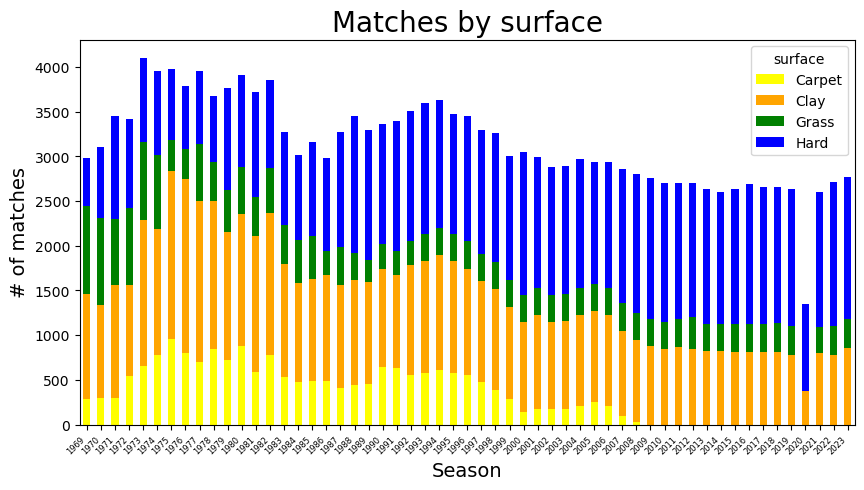

In [4077]:
surface_colors = {
    'Clay': 'orange',     # Light Salmon
    'Hard': 'blue',     # Steel Blue
    'Grass': 'green',    # Pale Green
    'Carpet': 'yellow'    # Goldenrod (if applicable)
}
colors = [surface_colors[surface] for surface in df_pivot.columns]



df_pivot = df_surf.pivot(index='season', columns='surface', values='updated_tourney_counts')
ax = df_pivot.plot(kind='bar', stacked=True, figsize = (10,5),color=colors)
ax.set_xlabel('Season',fontsize=14)
ax.set_ylabel('# of matches',fontsize=14)
ax.set_title('Matches by surface',fontsize=20)
plt.xticks(rotation=45, ha='right',fontsize=6)
plt.savefig('num_matches.png',format='png')
plt.show()

In [4079]:
df_grouped = df_69_23.groupby(['season', 'surface']).agg(tourney_count=('tourney_id', 'nunique')).reset_index()
surf_pct=df_grouped.groupby('season')['tourney_count'].apply(calc_pct).reset_index(drop=True)
df_grouped['surf_pct'] = surf_pct
#totals_without_nulls = df_69_23.dropna(subset=['surface']).groupby('season').size()
#null_counts = df_69_23[df_69_23['surface'].isnull()].groupby('season').size()
#null_counts.name = 'null_count'
#df_surf = df_grouped.merge(null_counts, how='left',left_on = 'season', right_index=True)
#df_surf['updated_tourney_counts'] = (df_surf['tourney_count'] + (df_surf['null_count'].fillna(0)*df_surf['surf_pct'])).round().astype(int)
df_grouped

,season,surface,tourney_count,surf_pct
0,1969,Carpet,16,0.179775
1,1969,Clay,30,0.337079
2,1969,Grass,19,0.213483
3,1969,Hard,24,0.269663
4,1970,Carpet,16,0.179775
...,...,...,...,...
199,2022,Grass,8,0.112676
200,2022,Hard,42,0.591549
201,2023,Clay,21,0.313433
202,2023,Grass,8,0.119403


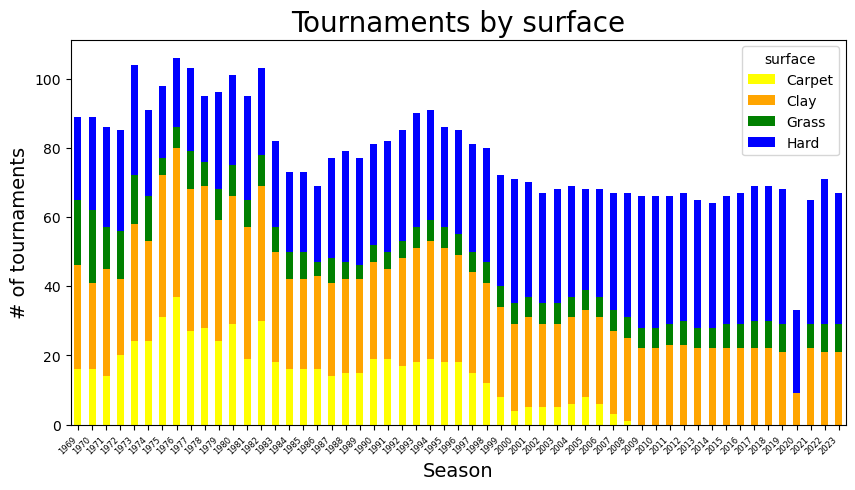

In [4081]:
surface_colors = {
    'Clay': 'orange',     # Light Salmon
    'Hard': 'blue',     # Steel Blue
    'Grass': 'green',    # Pale Green
    'Carpet': 'yellow'    # Goldenrod (if applicable)
}
colors = [surface_colors[surface] for surface in df_pivot.columns]

df_pivot = df_grouped.pivot(index='season', columns='surface', values='tourney_count')
ax = df_pivot.plot(kind='bar', stacked=True, figsize = (10,5),color=colors)

ax.set_xlabel('Season',fontsize=14)
ax.set_ylabel('# of tournaments', fontsize=14)
ax.set_title('Tournaments by surface',fontsize=20)
plt.xticks(rotation=45, ha='right',fontsize=6)
plt.savefig('Num_tourneys.png',format='png')
plt.show()

In [4083]:
# df_pivot = df_surf.pivot(index='season', columns='surface', values='updated_tourney_counts')
# ax = df_pivot.plot(kind='bar', stacked=True, figsize = (20,5))
# ax.set_xlabel('Season')
# ax.set_ylabel('# of matches')
# ax.set_title('Matches by surface')
# plt.show()

In [4085]:
df_full['winner_seed'] = pd.to_numeric(df_full['winner_seed'], errors='coerce')
df_full.loc[df_full['surface']=='Carpet'].sort_values('winner_seed')[['season','tourney_name','winner_name','winner_seed']].drop_duplicates(subset=['tourney_name'])

,season,tourney_name,winner_name,winner_seed
15231,2008,Lyon,Andy Roddick,1.0
42750,1996,Moscow,Yevgeny Kafelnikov,1.0
94232,1991,Vienna,Michael Stich,1.0
94294,1991,Stockholm Masters,Stefan Edberg,1.0
94372,1991,Paris Masters,Stefan Edberg,1.0
...,...,...,...,...
190344,2000,Davis Cup WG R1: RUS vs BEL,Yevgeny Kafelnikov,NaN
190402,2000,Davis Cup G1 QF: JPN vs KOR,Hyung Taik Lee,NaN
190414,2000,Davis Cup G1 R1: UKR vs POR,Andrey Dernovskiy,NaN
190736,2014,Davis Cup G2 R1: BIH vs GRE,Mirza Basic,NaN


In [4087]:
df_winner_country = df_full[df_full['round'] == 'F'][['season','tourney_id','tourney_level','tourney_name','surface','winner_id','winner_name','winner_ioc','winner_rank','loser_id','loser_name','loser_ioc','loser_rank']]

In [4089]:
# incorrect methodology for obtaining winners
# df_winner_country = df_full.loc[df_full.groupby('tourney_id')
# ['match_num'].idxmax()][['season','tourney_id','tourney_level','tourney_name','surface','winner_id','winner_name','winner_ioc','winner_rank','loser_id','loser_name','loser_ioc','loser_rank']]

In [4092]:
df_tourney_winners_sans_dc = df_winner_country[df_winner_country['tourney_level'] != 'D']

In [4094]:
df_tourney_winners_sans_dc_count =  df_tourney_winners_sans_dc.groupby(['winner_id','winner_name','winner_ioc']).size().reset_index(name='count').sort_values('count',ascending=False)

In [4097]:
df_tourney_winners_sans_dc_count

,winner_id,winner_name,winner_ioc,count
104,100284,Jimmy Connors,USA,110
447,103819,Roger Federer,SUI,103
504,104925,Novak Djokovic,SRB,99
175,100656,Ivan Lendl,USA,95
496,104745,Rafael Nadal,ESP,92
...,...,...,...,...
359,102287,Albert Portas,ESP,1
77,100185,Patrick Proisy,FRA,1
76,100184,Lars Elvstrom,DEN,1
364,102369,Julien Boutter,FRA,1


In [4099]:
!pip install kaleido

In [4100]:
import kaleido
import orca
print(kaleido.__version__)

0.2.1


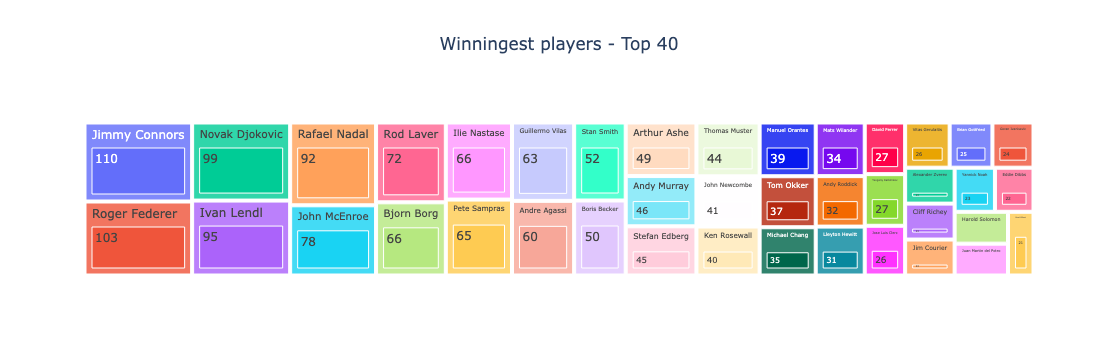

In [4103]:
import plotly.express as px
import matplotlib.pyplot as plt

df = df_tourney_winners_sans_dc_count.head(40).copy()
df = df.sort_values(by='count', ascending=False)

# Create the treemap
fig = px.treemap(
    df,
    path=['winner_name','count'],
    values='count',
    title='Winningest players - Top 40'
)

fig.update_layout(
    title={
        'text': 'Winningest players - Top 40',
        'x': 0.5,  # Center the title (x=0.5 is centered)
        'xanchor': 'center'
    }
)

# Show the plotx
#fig.write_image('max-win.png', engine='orca')
fig.show()

In [4105]:
df_tourney_winners_sans_dc_count.loc[df_tourney_winners_sans_dc_count['winner_name']=='Rafael Nadal']

,winner_id,winner_name,winner_ioc,count
496,104745,Rafael Nadal,ESP,92


In [4107]:
df_temp_num_won_by_ctry = df_tourney_winners_sans_dc_count.groupby('winner_ioc').agg({'count':'sum'}).reset_index().sort_values('count',ascending=False)

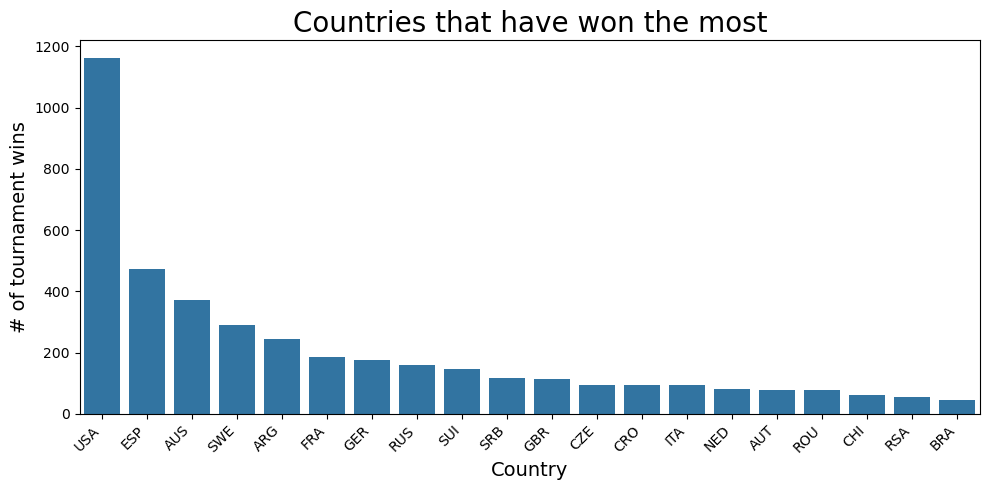

In [4109]:
df_temp_num_won_by_ctry.head(20)
plt.figure(figsize=(10,5))
sns.barplot(x=df_temp_num_won_by_ctry.head(20)['winner_ioc'], y=df_temp_num_won_by_ctry.head(20)['count'])
plt.xlabel('Country',fontsize=14)
plt.ylabel('# of tournament wins',fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.title('Countries that have won the most',fontsize=20)
plt.tight_layout()
plt.savefig('country_tourneys.png',format='png')
plt.show()

In [4112]:
df_temp_num_won_by_ctry.shape

(67, 2)

In [4114]:
def create_distr(df,country):

    max_bin_edge = df['count'].max() // 5 + 1
    bins = []
    bins_labels = []
    for i in range(max_bin_edge+1):
        bins.append(i*5)
        if i<max_bin_edge:
            bins_labels.append(f'{(i)*5} to {(i+1)*5}')
            
    # Cut the 'count' into bins
    df['win_bins'] = pd.cut(df['count'], bins=bins, labels=bins_labels)
    
    # Compute the distribution
    win_bin_distribution = df['win_bins'].value_counts().sort_index()
    
    # Plotting
    plt.figure(figsize=(10, 5))
    ax = win_bin_distribution.plot(kind='bar',rot=45,figsize=(10,5)) #color='coral', edgecolor='black')
    for p in ax.patches:
        ax.annotate(
            f'{p.get_height()}',  # The Y value (number of players)
            (p.get_x() + p.get_width() / 2., p.get_height()),  # Position the text in the middle of the bar width and at the top of the bar
            ha='center', va='bottom',  # Center horizontally and position at the top
            fontsize=10, color='black',
            xytext=(0, 3),  # Slight offset above the bar
            textcoords='offset points'
        )
    
    plt.xlabel('# of title wins',fontsize=14)
    plt.ylabel('# of players',fontsize=14)
    plt.title(f'# of title wins among players from {country} ',fontsize=20)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    plt.savefig(f'{country}-bin.png',format='png')   
    
    plt.show()

/var/folders/pc/d4jq7b1522b7sxkg3p93hs3r0000gn/T/ipykernel_30229/1163614965.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



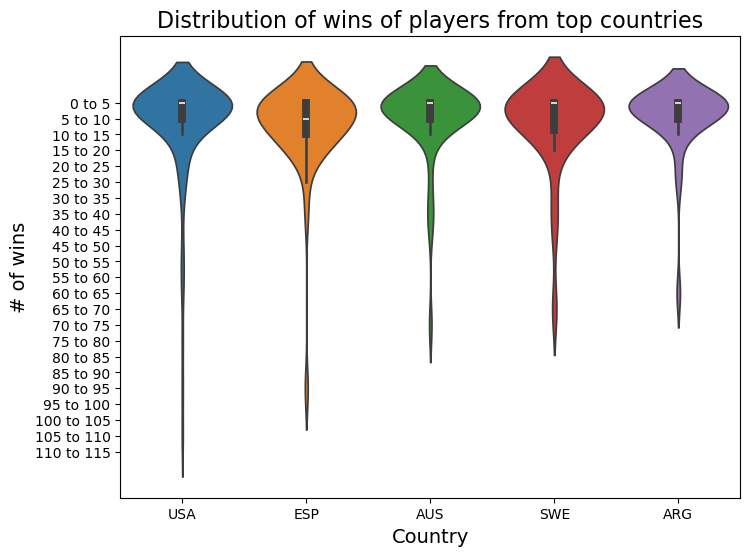

In [4116]:
df_test1 = df_tourney_winners_sans_dc_count.loc[df_tourney_winners_sans_dc_count['winner_ioc'].isin(['USA','ESP','AUS','SWE','ARG' ])]
max_bin_edge = df_test1['count'].max() // 5 + 1
bins = []
bins_labels = []
for i in range(max_bin_edge+1):
    bins.append(i*5)
    if i<max_bin_edge:
        bins_labels.append(f'{(i)*5} to {(i+1)*5}')
        
# Cut the 'count' into bins
df_test1['win_bins'] = pd.cut(df_test1['count'], bins=bins, labels=bins_labels)

# Compute the distribution
win_bin_distribution = df_test1['win_bins'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
sns.violinplot(x='winner_ioc', y='win_bins', data=df_test1,hue='winner_ioc')
plt.xlabel('Country', fontsize=14)  # Label for x-axis
plt.ylabel('# of wins', fontsize=14)  # Label for y-axis
plt.title('Distribution of wins of players from top countries', fontsize=16)  # Title of the plot
plt.savefig('violin-bin.png',format='png')
plt.show()


/var/folders/pc/d4jq7b1522b7sxkg3p93hs3r0000gn/T/ipykernel_30229/1155845289.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



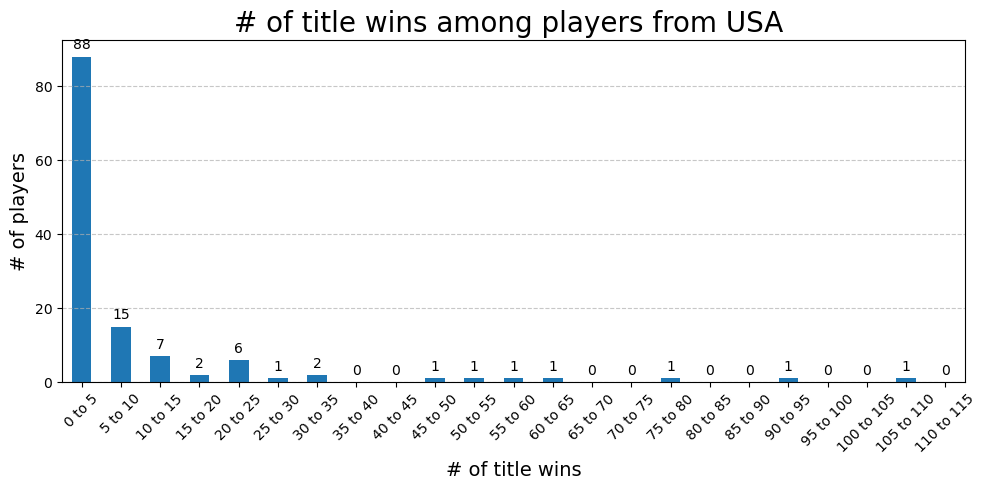

/var/folders/pc/d4jq7b1522b7sxkg3p93hs3r0000gn/T/ipykernel_30229/1155845289.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



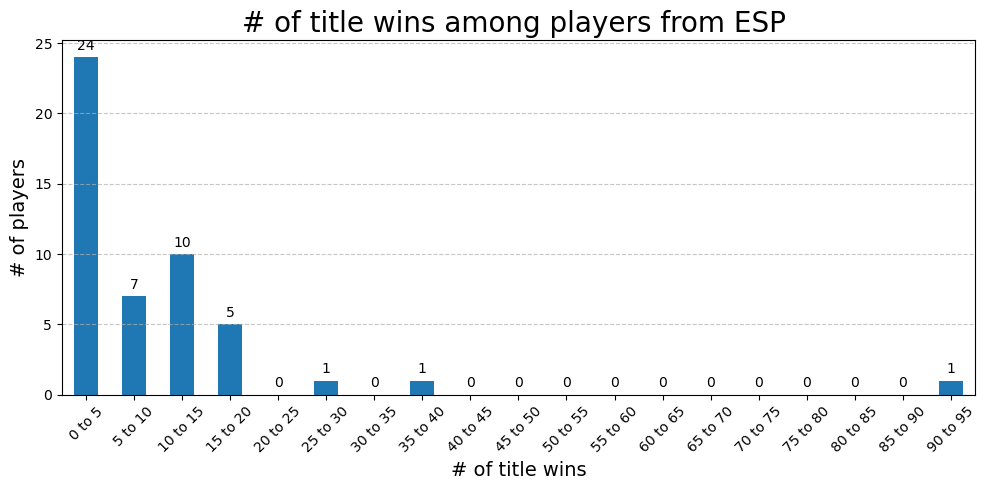

/var/folders/pc/d4jq7b1522b7sxkg3p93hs3r0000gn/T/ipykernel_30229/1155845289.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



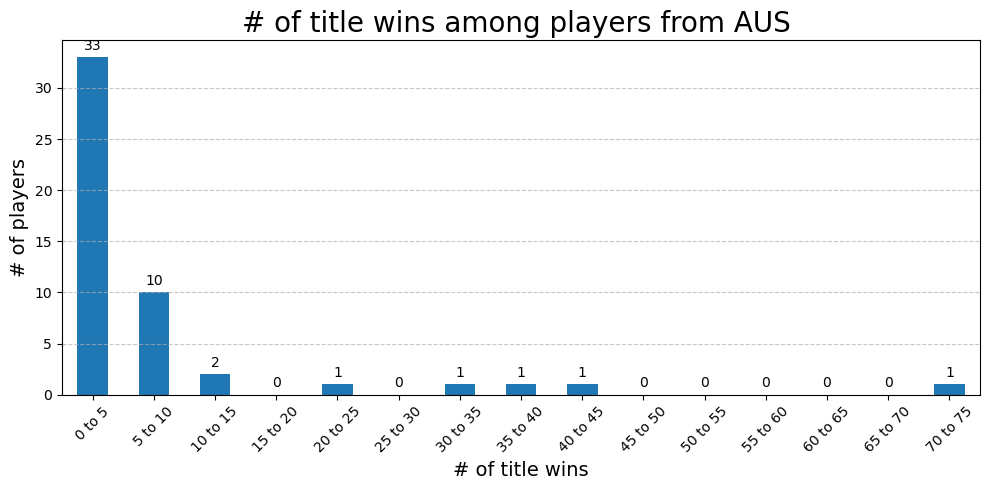

/var/folders/pc/d4jq7b1522b7sxkg3p93hs3r0000gn/T/ipykernel_30229/1155845289.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



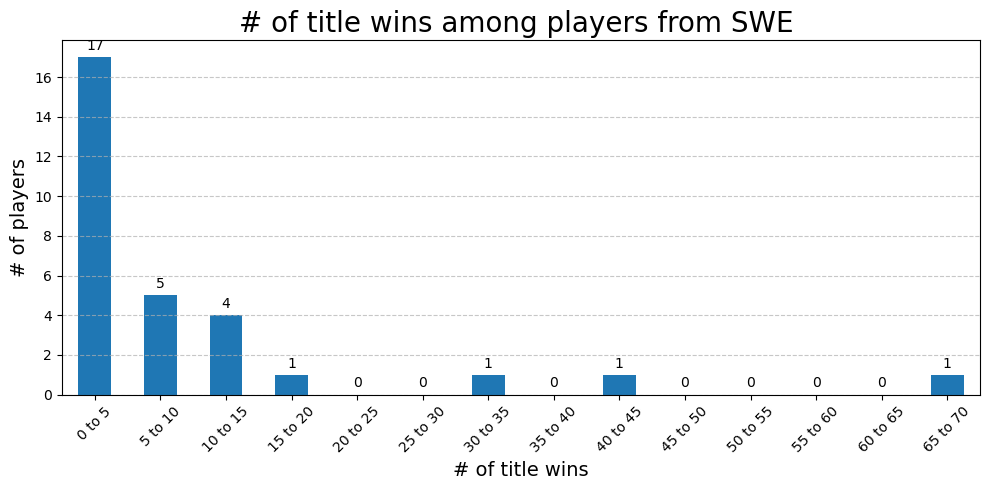

/var/folders/pc/d4jq7b1522b7sxkg3p93hs3r0000gn/T/ipykernel_30229/1155845289.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



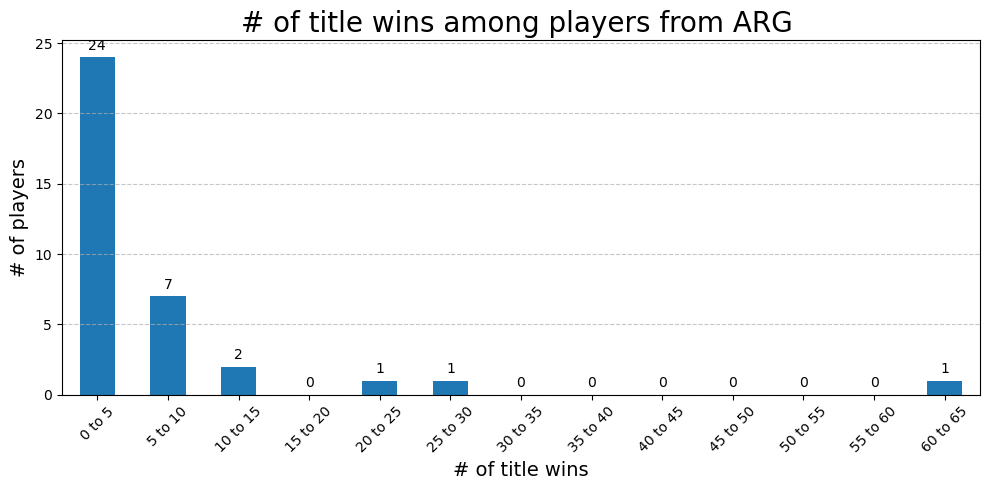

/var/folders/pc/d4jq7b1522b7sxkg3p93hs3r0000gn/T/ipykernel_30229/1155845289.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



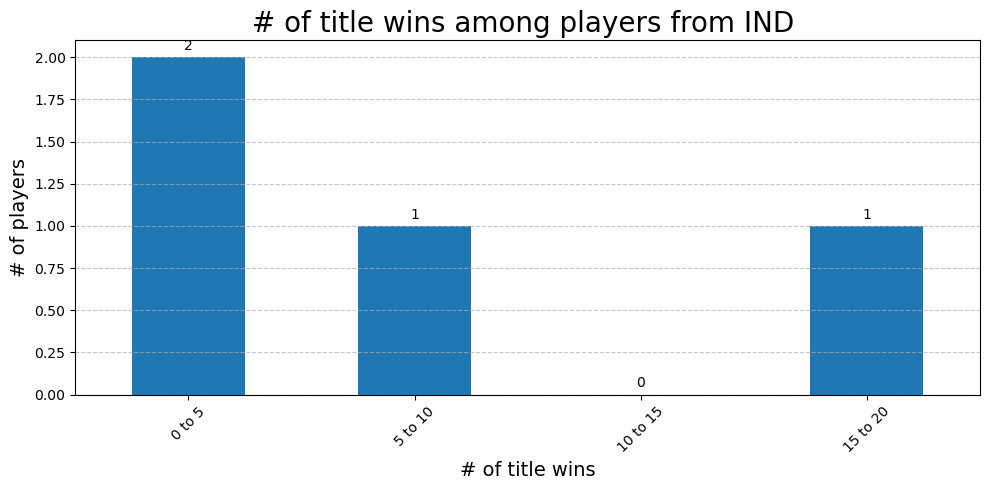

/var/folders/pc/d4jq7b1522b7sxkg3p93hs3r0000gn/T/ipykernel_30229/1155845289.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



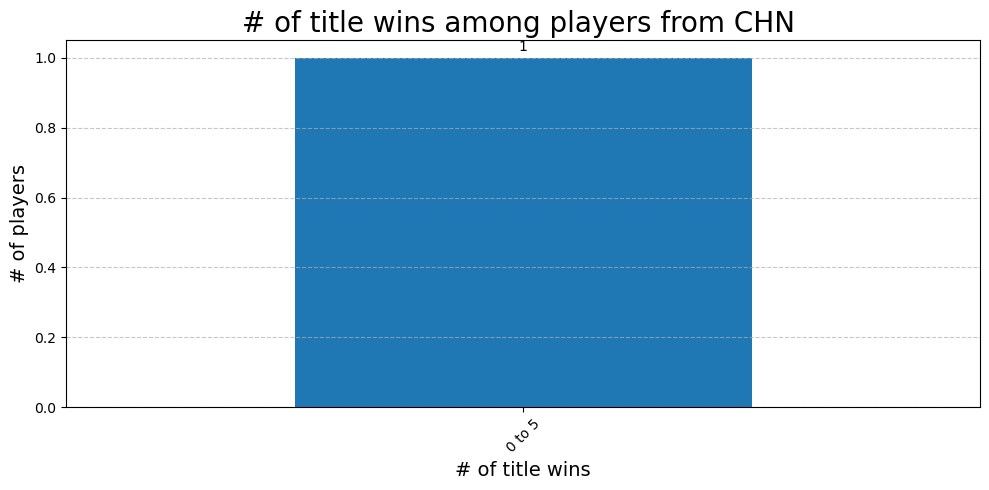

/var/folders/pc/d4jq7b1522b7sxkg3p93hs3r0000gn/T/ipykernel_30229/1155845289.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



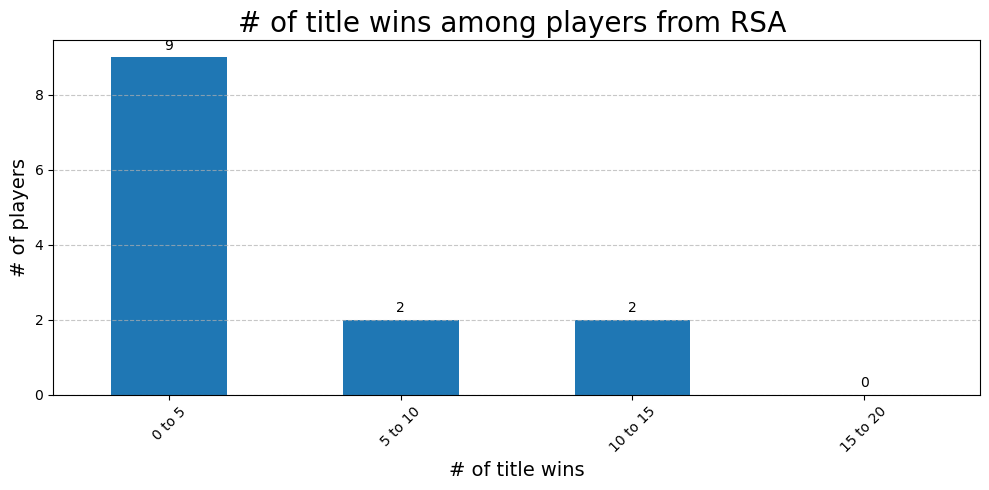

/var/folders/pc/d4jq7b1522b7sxkg3p93hs3r0000gn/T/ipykernel_30229/1155845289.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



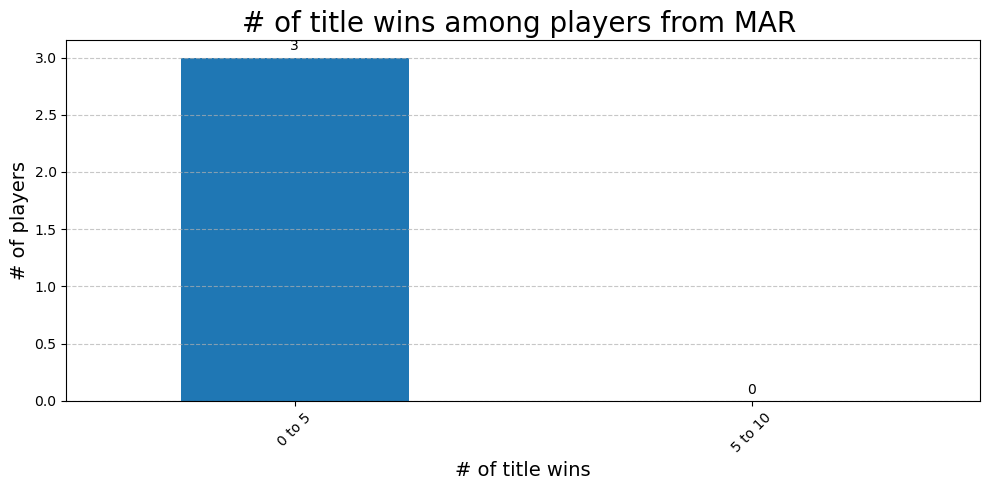

In [4119]:
countries_of_interest = ['USA','ESP','AUS','SWE','ARG','IND','CHN','RSA','MAR']
for country in countries_of_interest:
    df_temp = df_tourney_winners_sans_dc_count.loc[(df_tourney_winners_sans_dc_count['winner_ioc'] == country)]
    create_distr(df_temp,country)

In [4123]:
ee_cat_df = pd.read_csv('/Users/amiyo/bootcamp/Project-ATP_TENNIS/EEU_csv_Country_names.csv')

In [4126]:
df_win_nodc_ee= df_tourney_winners_sans_dc_count.merge(ee_cat_df,how='left', left_on='winner_ioc', right_on = 'ioc')
df_win_nodc_ee.head(1)

,winner_id,winner_name,winner_ioc,count,ioc,country_name,EE_flag
0,100284,Jimmy Connors,USA,110,USA,United States,NaN


In [4128]:
df_win_nodc_ee['winner_country'] = df_win_nodc_ee.apply(lambda row: row['country_name'] if pd.isnull(row['EE_flag'])  else 'Eastern Europe',axis=1)

In [4130]:
df_win_nodc_ee.head()

,winner_id,winner_name,winner_ioc,count,ioc,country_name,EE_flag,winner_country
0,100284,Jimmy Connors,USA,110,USA,United States,NaN,United States
1,103819,Roger Federer,SUI,103,SUI,Switzerland,NaN,Switzerland
2,104925,Novak Djokovic,SRB,99,SRB,Serbia,1.0,Eastern Europe
3,100656,Ivan Lendl,USA,95,USA,United States,NaN,United States
4,104745,Rafael Nadal,ESP,92,ESP,Spain,NaN,Spain


In [4132]:
df_win_nodc_ee_grouped = df_win_nodc_ee.groupby('winner_country').agg({'count':'sum'}).reset_index().sort_values(by='count',ascending=False).head(4)

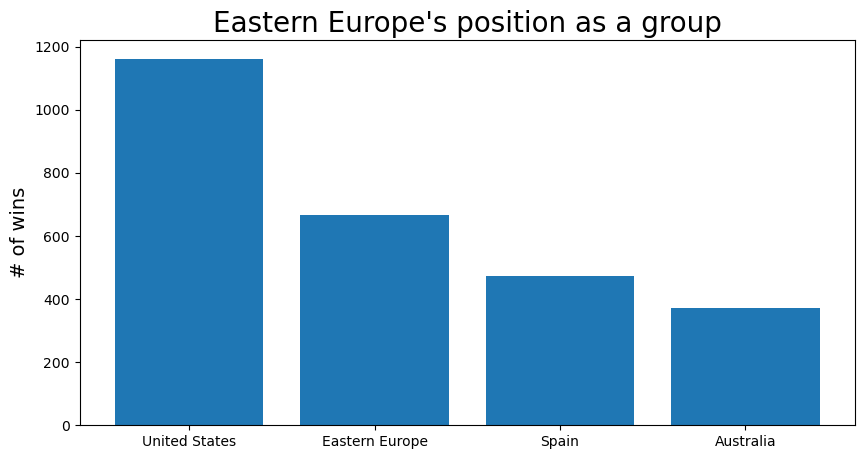

In [4134]:
plt.figure(figsize=(10, 5))
plt.bar(df_win_nodc_ee_grouped['winner_country'],df_win_nodc_ee_grouped['count'])
plt.xlabel('',fontsize=14)
plt.ylabel('# of wins',fontsize=14)
plt.title("Eastern Europe's position as a group",fontsize=20)
plt.savefig('Easter Europe.png',format='png')
plt.show()

In [4136]:
df_tourney_winners_sans_dc_count

,winner_id,winner_name,winner_ioc,count
104,100284,Jimmy Connors,USA,110
447,103819,Roger Federer,SUI,103
504,104925,Novak Djokovic,SRB,99
175,100656,Ivan Lendl,USA,95
496,104745,Rafael Nadal,ESP,92
...,...,...,...,...
359,102287,Albert Portas,ESP,1
77,100185,Patrick Proisy,FRA,1
76,100184,Lars Elvstrom,DEN,1
364,102369,Julien Boutter,FRA,1


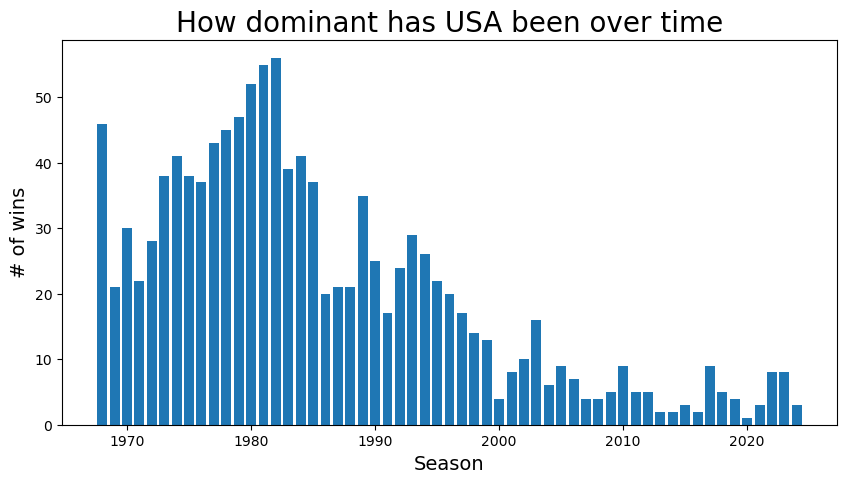

In [4138]:
df_temp = df_tourney_winners_sans_dc.groupby(['winner_ioc','season']).agg('count')
#df_temp.loc[df_temp['winner_ioc'] == 'USA']
df_usa = df_temp.loc['USA'][['tourney_id']].rename(columns={'tourney_id': 'count'}).reset_index()
plt.figure(figsize=(10, 5))
plt.bar(df_usa['season'],df_usa['count'])
plt.xlabel('Season',fontsize=14)
plt.ylabel('# of wins',fontsize=14)
plt.title('How dominant has USA been over time',fontsize=20)
plt.savefig('USA-dom.png',format='png')
plt.show()

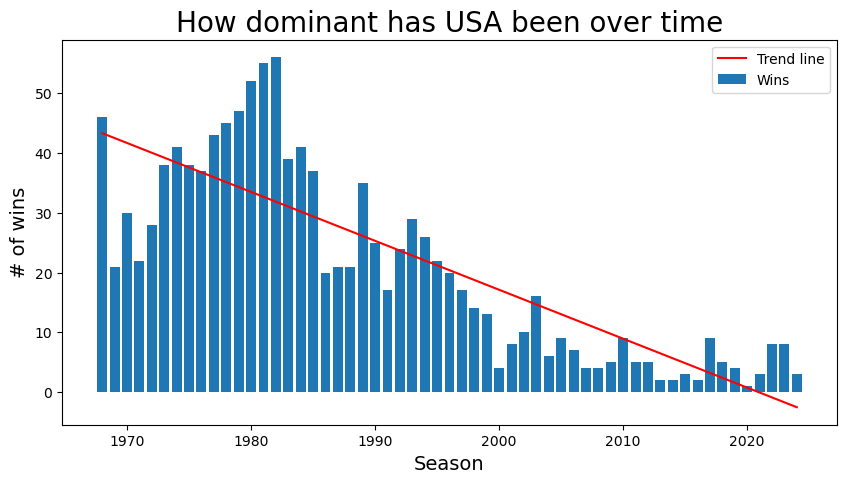

In [4140]:
df_temp = df_tourney_winners_sans_dc.groupby(['winner_ioc', 'season']).agg('count')

# Filter for USA data
df_usa = df_temp.loc['USA'][['tourney_id']].rename(columns={'tourney_id': 'count'}).reset_index()

# Plotting the bar chart
plt.figure(figsize=(10, 5))
plt.bar(df_usa['season'], df_usa['count'], label='Wins')

# Fit a linear trend line
z = np.polyfit(df_usa.index, df_usa['count'], 1)  # 1st degree polynomial (linear)
p = np.poly1d(z)

# Plot the trend line
plt.plot(df_usa['season'], p(df_usa.index), color='red', label='Trend line')

# Labels and title
plt.xlabel('Season', fontsize=14)
plt.ylabel('# of wins', fontsize=14)
plt.title('How dominant has USA been over time', fontsize=20)

# Show legend
plt.legend()

# Show plot
plt.show()

In [4142]:
df_usa[df_usa['season'] >= 2000]['count'].sum()

142

In [4144]:
df_usa[df_usa['season'] < 2000]['count'].sum()

1020

<Axes: xlabel='count', ylabel='season'>

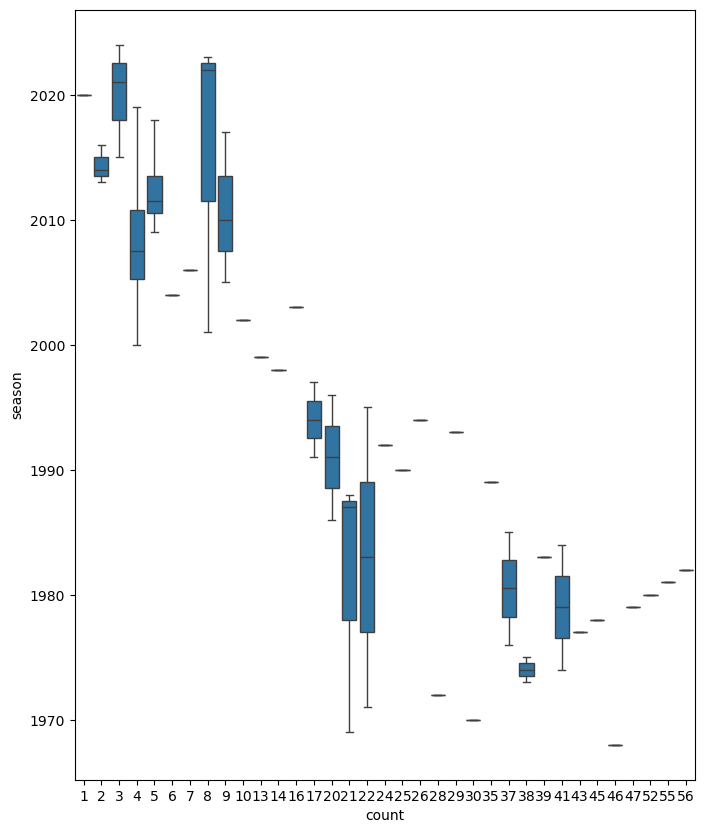

In [4146]:
plt.figure(figsize=(8, 10))  # Adjust the width and height accordingly
sns.boxplot(x=df_usa['count'],y=df_usa['season'])

In [4148]:
df_temp = df_tourney_winners_sans_dc.loc[df_tourney_winners_sans_dc['winner_ioc'] == 'USA'].groupby('season').agg(distinct_winners=('winner_id','nunique')).reset_index()

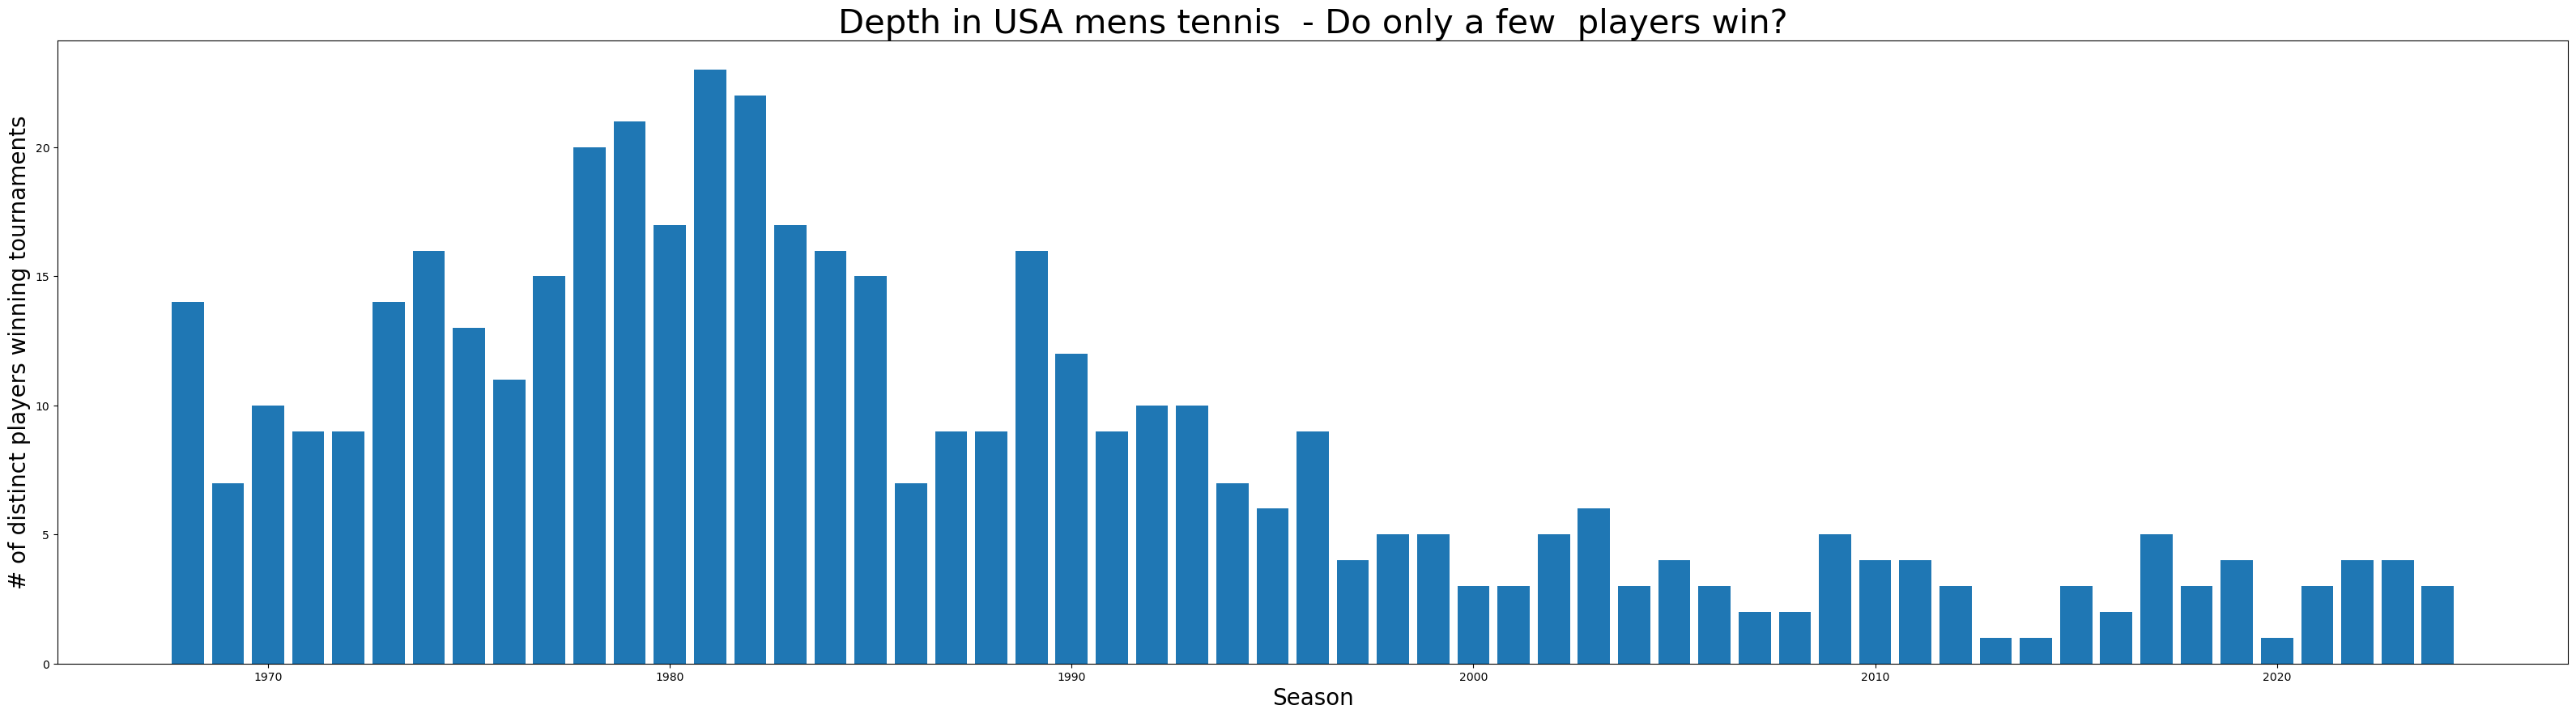

In [4150]:
plt.figure(figsize=(40, 10))
plt.bar(df_temp['season'],df_temp['distinct_winners'])
plt.xlabel('Season',fontsize=20)
plt.ylabel('# of distinct players winning tournaments',fontsize=20)
plt.title('Depth in USA mens tennis  - Do only a few  players win?',fontsize=30)
plt.show()

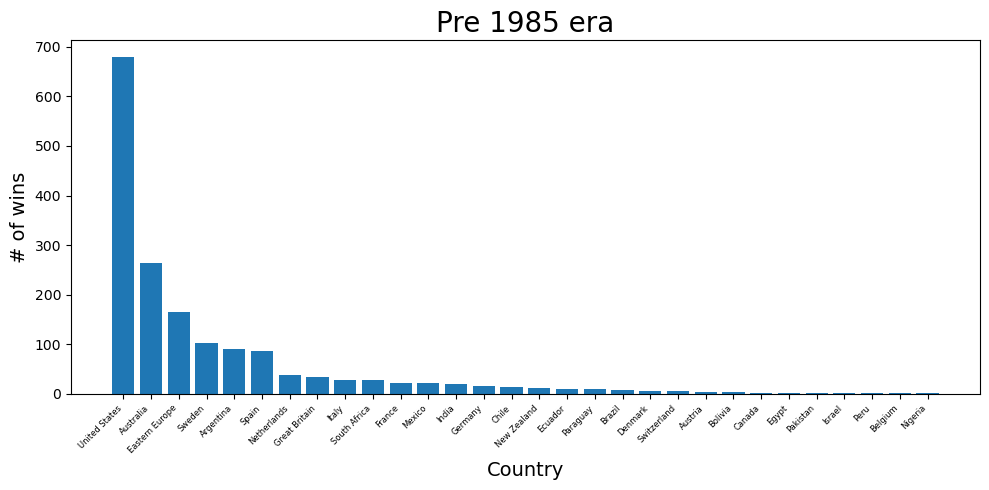

In [5107]:
df_tourney_winners_sans_dc_lt1985=df_tourney_winners_sans_dc.loc[df_tourney_winners_sans_dc['season'] < 1985].groupby('winner_ioc').agg({'winner_id':'count'}).reset_index().rename(columns={'winner_id': 'count'}).sort_values(by='count',ascending=False)

df_win_nodc_ee_lt1985= df_tourney_winners_sans_dc_lt1985.merge(ee_cat_df,how='left', left_on='winner_ioc', right_on = 'ioc')
df_win_nodc_ee_lt1985['winner_country'] =  df_win_nodc_ee_lt1985.apply(lambda row: row['country_name'] if pd.isnull(row['EE_flag'])  else 'Eastern Europe',axis=1)
df_win_nodc_ee_lt1985_grouped = df_win_nodc_ee_lt1985.groupby('winner_country').agg({'count':'sum'}).reset_index().sort_values(by='count', ascending=False)

plt.figure(figsize=(10, 5))

plt.bar(df_win_nodc_ee_lt1985_grouped['winner_country'],df_win_nodc_ee_lt1985_grouped['count'])
plt.xlabel('Country', fontsize=14)
plt.ylabel('# of wins', fontsize=14)
plt.xticks(rotation=45,ha='right',fontsize=6)
plt.title('Pre 1985 era', fontsize=20)
plt.savefig('Pre 1985.png',format='png')
plt.tight_layout()
plt.show()



In [5114]:
df_win_nodc_ee_lt1985_grouped

,winner_country,count
29,United States,679
1,Australia,264
9,Eastern Europe,165
27,Sweden,103
0,Argentina,90
26,Spain,86
19,Netherlands,37
14,Great Britain,33
17,Italy,27
25,South Africa,27


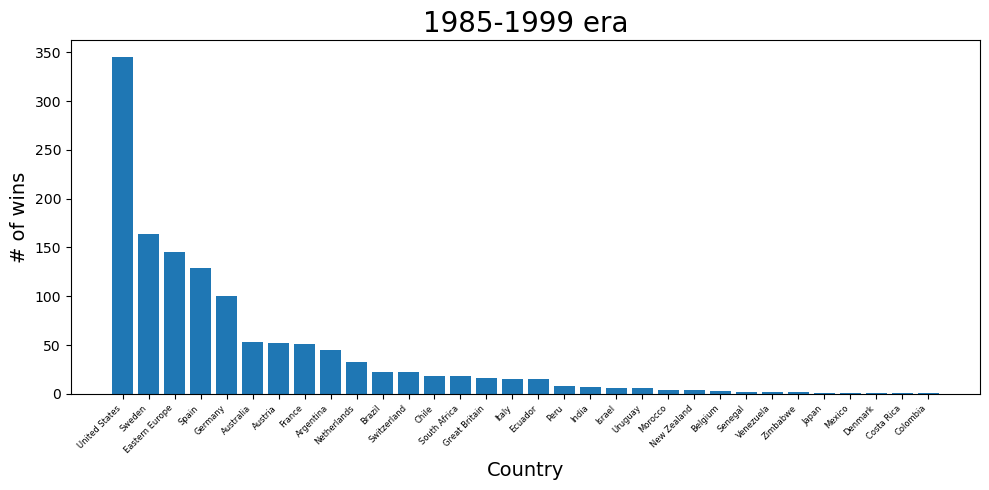

In [5111]:
df_tourney_winners_sans_dc_fr1985_1999=df_tourney_winners_sans_dc.loc[(df_tourney_winners_sans_dc['season'] >= 1985) & (df_tourney_winners_sans_dc['season'] <= 2000)].groupby('winner_ioc').agg({'winner_id':'count'}).reset_index().rename(columns={'winner_id': 'count'}).sort_values(by='count',ascending=False)


df_win_nodc_ee_fr1985_1999= df_tourney_winners_sans_dc_fr1985_1999.merge(ee_cat_df,how='left', left_on='winner_ioc', right_on = 'ioc')
df_win_nodc_ee_fr1985_1999['winner_country'] =  df_win_nodc_ee_fr1985_1999.apply(lambda row: row['country_name'] if pd.isnull(row['EE_flag'])  else 'Eastern Europe',axis=1)
df_win_nodc_ee_fr1985_1999_grouped = df_win_nodc_ee_fr1985_1999.groupby('winner_country').agg({'count':'sum'}).reset_index().sort_values(by='count', ascending=False)

plt.figure(figsize=(10, 5))

plt.bar(df_win_nodc_ee_fr1985_1999_grouped['winner_country'],df_win_nodc_ee_fr1985_1999_grouped['count'])
plt.xlabel('Country', fontsize=14)
plt.ylabel('# of wins', fontsize=14)
plt.xticks(rotation=45,ha='right',fontsize=6)
plt.title('1985-1999 era', fontsize=20)
plt.savefig('1985-1999.png',format='png')
plt.tight_layout()
plt.show()

In [5116]:
df_win_nodc_ee_fr1985_1999_grouped

,winner_country,count
28,United States,345
26,Sweden,164
9,Eastern Europe,145
25,Spain,129
12,Germany,100
1,Australia,53
2,Austria,52
11,France,51
0,Argentina,45
20,Netherlands,33


In [4152]:
#df_temp_num_won_by_ctry.loc[df_temp_num_won_by_ctry['season'] >= 2000]
df_tourney_winners_sans_dc_fr2000=df_tourney_winners_sans_dc.loc[df_tourney_winners_sans_dc['season'] >= 2000].groupby('winner_ioc').agg({'winner_id':'count'}).reset_index().rename(columns={'winner_id': 'count'}).sort_values(by='count',ascending=False)

Text(0.5, 1.0, 'Since the 2000s American dominance has waned')

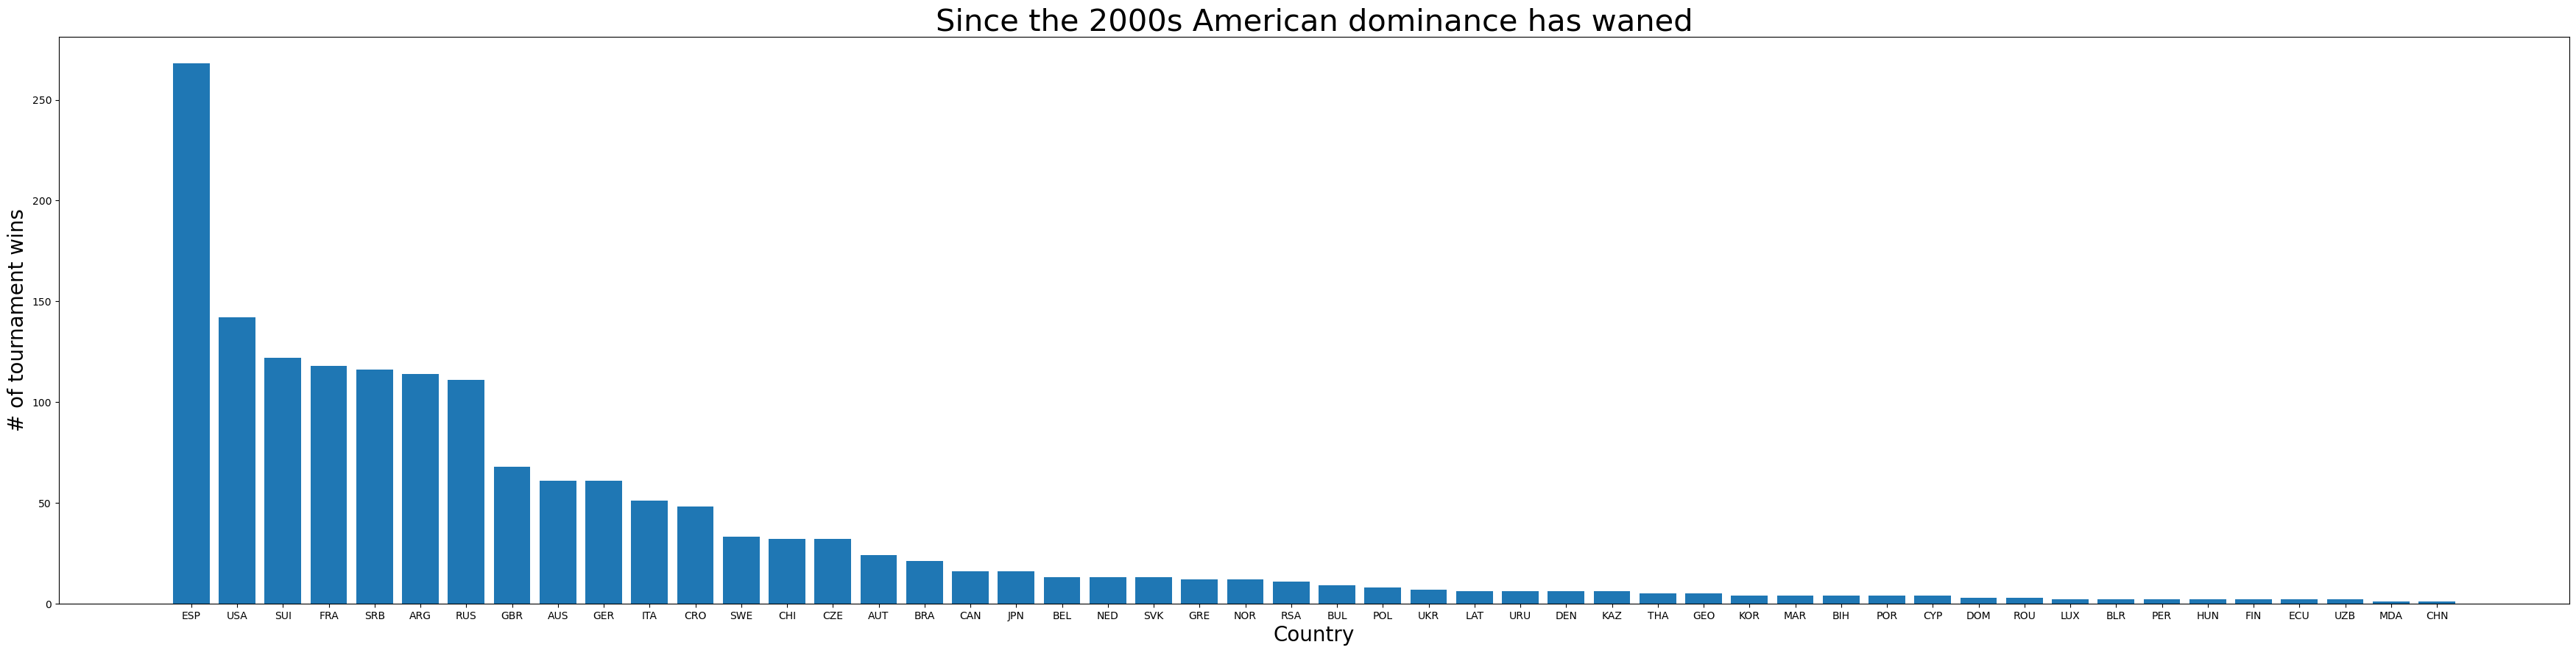

In [4154]:
plt.figure(figsize=(44, 10))
plt.bar(df_tourney_winners_sans_dc_fr2000['winner_ioc'],df_tourney_winners_sans_dc_fr2000['count'])
plt.xlabel('Country',fontsize=20)
plt.ylabel('# of tournament wins',fontsize=20)
plt.title('Since the 2000s American dominance has waned',fontsize=30)

In [4156]:
df_win_nodc_ee_fr2000= df_tourney_winners_sans_dc_fr2000.merge(ee_cat_df,how='left', left_on='winner_ioc', right_on = 'ioc')
df_win_nodc_ee_fr2000['winner_country'] =  df_win_nodc_ee_fr2000.apply(lambda row: row['country_name'] if pd.isnull(row['EE_flag'])  else 'Eastern Europe',axis=1)
df_win_nodc_ee_fr2000_grouped = df_win_nodc_ee_fr2000.groupby('winner_country').agg({'count':'sum'}).reset_index().sort_values(by='count', ascending=False)


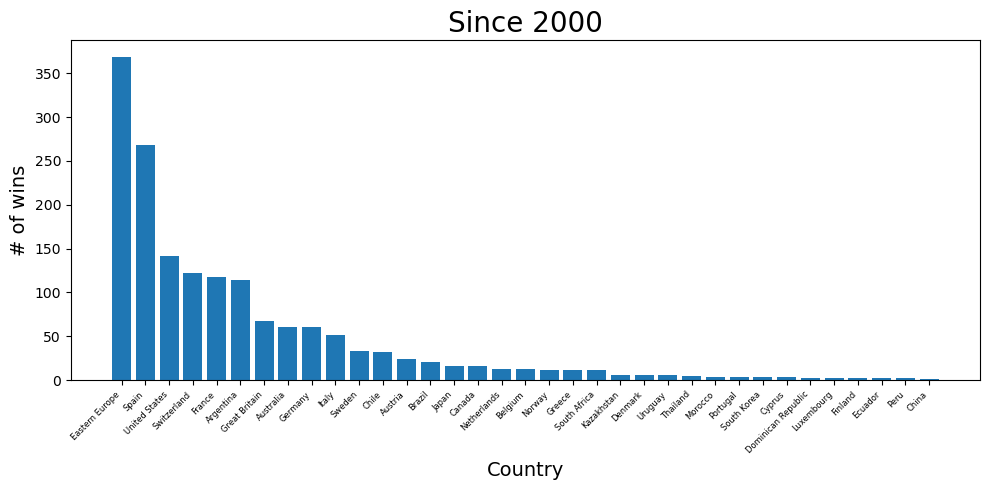

In [4158]:
plt.figure(figsize=(10, 5))

plt.bar(df_win_nodc_ee_fr2000_grouped['winner_country'],df_win_nodc_ee_fr2000_grouped['count'])
plt.xlabel('Country', fontsize=14)
plt.ylabel('# of wins', fontsize=14)
plt.xticks(rotation=45,ha='right',fontsize=6)
plt.title('Since 2000', fontsize=20)
plt.savefig('Since2000.png',format='png')
plt.tight_layout()
plt.show()


In [4160]:
#df_tourney_winners_sans_dc_fr2000
ee_cat_df

,ioc,country_name,EE_flag
0,AFG,Afghanistan,NaN
1,ALB,Albania,1.0
2,ALG,Algeria,NaN
3,AND,Andorra,NaN
4,ANG,Angola,NaN
...,...,...,...
201,VIE,Vietnam,NaN
202,VIN,Saint Vincent and the Grenadines,NaN
203,YEM,Yemen,NaN
204,ZAM,Zambia,NaN


In [4162]:
df_69_23[df_69_23['tourney_id']  == '2019-580']

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,season,pair
139,2019-580,Australian Open,Hard,128.0,G,20190114,226,104925,1.0,NaN,...,16.0,13.0,3.0,8.0,1.0,9135.0,2.0,7480.0,2019,"(104745, 104925)"
140,2019-580,Australian Open,Hard,128.0,G,20190114,217,126774,14.0,NaN,...,31.0,24.0,2.0,3.0,15.0,2095.0,3.0,6420.0,2019,"(103819, 126774)"
141,2019-580,Australian Open,Hard,128.0,G,20190114,214,105683,16.0,NaN,...,12.0,13.0,14.0,20.0,17.0,1900.0,4.0,6385.0,2019,"(100644, 105683)"
142,2019-580,Australian Open,Hard,128.0,G,20190114,188,126207,NaN,NaN,...,23.0,21.0,10.0,14.0,39.0,1080.0,6.0,4810.0,2019,"(104731, 126207)"
143,2019-580,Australian Open,Hard,128.0,G,20190114,216,105138,22.0,NaN,...,28.0,24.0,8.0,13.0,24.0,1605.0,7.0,4160.0,2019,"(105138, 105227)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,2019-580,Australian Open,Hard,128.0,G,20190114,177,105936,NaN,NaN,...,23.0,17.0,7.0,11.0,93.0,620.0,96.0,599.0,2019,"(105539, 105936)"
262,2019-580,Australian Open,Hard,128.0,G,20190114,189,104312,NaN,NaN,...,10.0,14.0,7.0,13.0,35.0,1170.0,72.0,740.0,2019,"(104312, 111442)"
263,2019-580,Australian Open,Hard,128.0,G,20190114,191,105341,NaN,NaN,...,26.0,25.0,2.0,5.0,102.0,573.0,97.0,593.0,2019,"(105341, 124187)"
264,2019-580,Australian Open,Hard,128.0,G,20190114,192,104607,NaN,NaN,...,15.0,12.0,2.0,7.0,57.0,865.0,58.0,860.0,2019,"(104607, 104898)"


In [4166]:
rankings_ditc = {}

df_rankings_full = pd.DataFrame()

count = 0
for file in os.listdir('./'):
    file_match = re.match(r'atp_rankings_.*',file)
    if file_match:
        print(f'Reading file {file_match} and file itself is {file}')
        df = pd.read_csv(file)
        #df['season'] = pd.to_datetime(file_match.group(1),format='%Y').year
        df_rankings_full = pd.concat([df_rankings_full,df], axis=0)
        
        #atp_seasons[file_match.group(0)] = df
        count += 1
print(f'Total rankings files added: {count}')

Reading file <re.Match object; span=(0, 20), match='atp_rankings_00s.csv'> and file itself is atp_rankings_00s.csv
Reading file <re.Match object; span=(0, 20), match='atp_rankings_20s.csv'> and file itself is atp_rankings_20s.csv
Reading file <re.Match object; span=(0, 20), match='atp_rankings_10s.csv'> and file itself is atp_rankings_10s.csv
Reading file <re.Match object; span=(0, 20), match='atp_rankings_70s.csv'> and file itself is atp_rankings_70s.csv
Reading file <re.Match object; span=(0, 20), match='atp_rankings_90s.csv'> and file itself is atp_rankings_90s.csv
Reading file <re.Match object; span=(0, 24), match='atp_rankings_current.csv'> and file itself is atp_rankings_current.csv
Reading file <re.Match object; span=(0, 20), match='atp_rankings_80s.csv'> and file itself is atp_rankings_80s.csv
Total rankings files added: 7


In [4169]:
df_player_rankings = df_rankings_full.merge(players_df,left_on='player', right_on='player_id', how='left')

In [4171]:
def chart_dominance_with_boundaries(country, threshold, year_boundaries, colors):
    df_us_player_rankings_top10 = df_player_rankings.loc[(df_player_rankings['ioc'] == country) & (df_player_rankings['rank'] <= threshold)]
    df_us_player_rankings_top10['season'] = pd.to_datetime(df_us_player_rankings_top10['ranking_date'].astype(str)).dt.year
    df_us_winners_sans_dc = df_tourney_winners_sans_dc.loc[df_tourney_winners_sans_dc['winner_ioc'] == country]
    df_us_winners_sans_dc_mgd = df_us_winners_sans_dc.merge(df_us_player_rankings_top10, how='left', left_on=['winner_id','season'], right_on=['player', 'season'])
    df_us_winners_sans_dc_mgd_nott10 = df_us_winners_sans_dc_mgd[df_us_winners_sans_dc_mgd['player'].isnull()]
    df_us_winners_sans_dc_mgd_nott10_fr_69_23 = df_us_winners_sans_dc_mgd_nott10[~df_us_winners_sans_dc_mgd_nott10['season'].isin([1968,1969,1970,1971,1972,2024])]

    df_us_winners_sans_dc_mgd_nott10_fr_69_23_counts = df_us_winners_sans_dc_mgd_nott10_fr_69_23.groupby('season').agg({'tourney_id': 'count'}).reset_index()
    df_us_player_rankings_top10['inv_rank'] = (11 - df_us_player_rankings_top10['rank']) / 20
    df_us_inv_rank = df_us_player_rankings_top10.groupby('season').agg({'inv_rank': 'sum'}).reset_index()

    date_spine = {'season': [date for date in range(1973, 2024)]}
    df_date_spine = pd.DataFrame(date_spine)
    df_us_dom_score = df_date_spine.merge(df_us_inv_rank, on='season', how='left')[['season', 'inv_rank']].fillna(0)
    df_halo_effect = df_us_dom_score.merge(df_us_winners_sans_dc_mgd_nott10_fr_69_23_counts, how='left', on='season').rename(columns={'tourney_id': 'count'})

    correlation = df_halo_effect['inv_rank'].corr(df_halo_effect['count'])

    # Create a new column to categorize seasons into ranges based on year boundaries
    def color_by_season(season, year_boundaries, colors):
        for i, (start, end) in enumerate(year_boundaries):
            if start <= season <= end:
                return colors[i]
        return 'gray'  # Default color if no range matches

    # Apply the function with the provided year boundaries and colors
    df_halo_effect['color'] = df_halo_effect['season'].apply(lambda x: color_by_season(x, year_boundaries, colors))

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Scatter plot with colors based on season ranges
    scatter = ax.scatter(df_halo_effect['inv_rank'], df_halo_effect['count'], c=df_halo_effect['color'])

    # Add annotations
    for i, txt in enumerate(df_halo_effect['season']):
        ax.annotate(txt, (df_halo_effect['inv_rank'].iloc[i], df_halo_effect['count'].iloc[i]))

    ax.set_xlabel('Dominance score',fontsize=14)  
    ax.set_ylabel('Count',fontsize=14)        
    ax.set_title(f'Halo Effect - {country}',fontsize=20)
    
    # Add a legend based on year boundaries
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label=f'{start}-{end}', markerfacecolor=colors[i], markersize=10)
        for i, (start, end) in enumerate(year_boundaries)
    ]
    ax.legend(handles=legend_elements, loc='upper left')

    #print(f'Correlation between dominance score and count of tournaments won for {country} is {correlation}')
    plt.savefig(f'{country}-dom_score.png',format='png')
    plt.show()

# Example usage


In [5121]:
def chart_dominance_with_boundaries(country, threshold, year_boundaries, colors):
    # Preprocessing steps for player rankings and winners data
    df_us_player_rankings_top10 = df_player_rankings.loc[(df_player_rankings['ioc'] == country) & (df_player_rankings['rank'] <= threshold)].copy()
    df_us_player_rankings_top10['season'] = pd.to_datetime(df_us_player_rankings_top10['ranking_date'].astype(str)).dt.year
    df_us_winners_sans_dc = df_tourney_winners_sans_dc.loc[df_tourney_winners_sans_dc['winner_ioc'] == country].copy()
    df_us_winners_sans_dc_mgd = df_us_winners_sans_dc.merge(df_us_player_rankings_top10, how='left', left_on=['winner_id','season'], right_on=['player', 'season'])
    df_us_winners_sans_dc_mgd_nott10 = df_us_winners_sans_dc_mgd[df_us_winners_sans_dc_mgd['player'].isnull()]
    df_us_winners_sans_dc_mgd_nott10_fr_69_23 = df_us_winners_sans_dc_mgd_nott10[~df_us_winners_sans_dc_mgd_nott10['season'].isin([1968,1969,1970,1971,1972,2024])]

    df_us_winners_sans_dc_mgd_nott10_fr_69_23_counts = df_us_winners_sans_dc_mgd_nott10_fr_69_23.groupby('season').agg({'tourney_id': 'count'}).reset_index()
    df_us_player_rankings_top10['inv_rank'] = (11 - df_us_player_rankings_top10['rank']) / 20
    df_us_inv_rank = df_us_player_rankings_top10.groupby('season').agg({'inv_rank': 'sum'}).reset_index()

    # Create a date spine for merging
    date_spine = {'season': [date for date in range(1973, 2024)]}
    df_date_spine = pd.DataFrame(date_spine)
    df_us_dom_score = df_date_spine.merge(df_us_inv_rank, on='season', how='left')[['season', 'inv_rank']].fillna(0)
    df_halo_effect = df_us_dom_score.merge(df_us_winners_sans_dc_mgd_nott10_fr_69_23_counts, how='left', on='season').rename(columns={'tourney_id': 'count'})

    # Loop over each year boundary and generate a chart
    for i, (start, end) in enumerate(year_boundaries):
        # Filter data for the current boundary range
        df_halo_effect_subset = df_halo_effect[(df_halo_effect['season'] >= start) & (df_halo_effect['season'] <= end)].copy()

        # Plotting
        fig, ax = plt.subplots(figsize=(10, 5))

        # Scatter plot
        scatter = ax.scatter(df_halo_effect_subset['inv_rank'], df_halo_effect_subset['count'], color=colors[i])

        # Add annotations for each season
        for j, txt in enumerate(df_halo_effect_subset['season']):
            ax.annotate(txt, (df_halo_effect_subset['inv_rank'].iloc[j], df_halo_effect_subset['count'].iloc[j]))

        # Set chart labels and title
        ax.set_xlabel('Dominance score', fontsize=14)
        ax.set_ylabel('Count', fontsize=14)
        ax.set_title(f'Halo Effect - {country} ({start}-{end})', fontsize=20)

        # Save and show the plot
        plt.savefig(f'{country}-dom_score_{start}_{end}.png', format='png')
        plt.show()

# Example usage


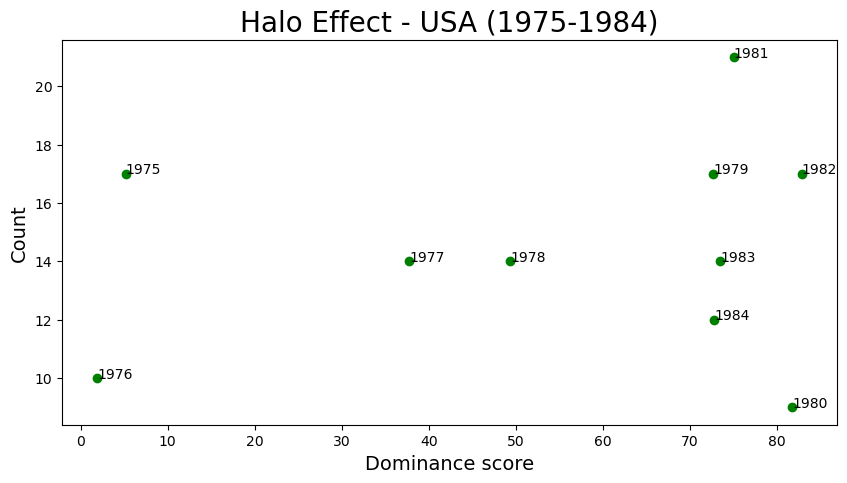

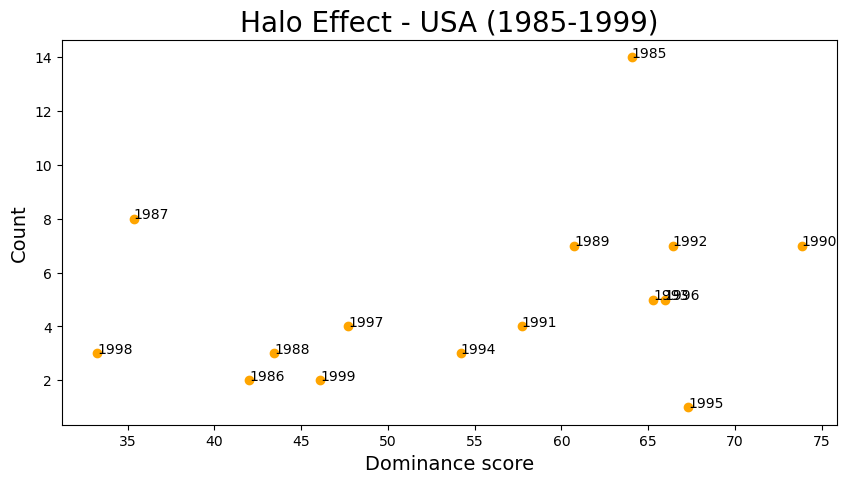

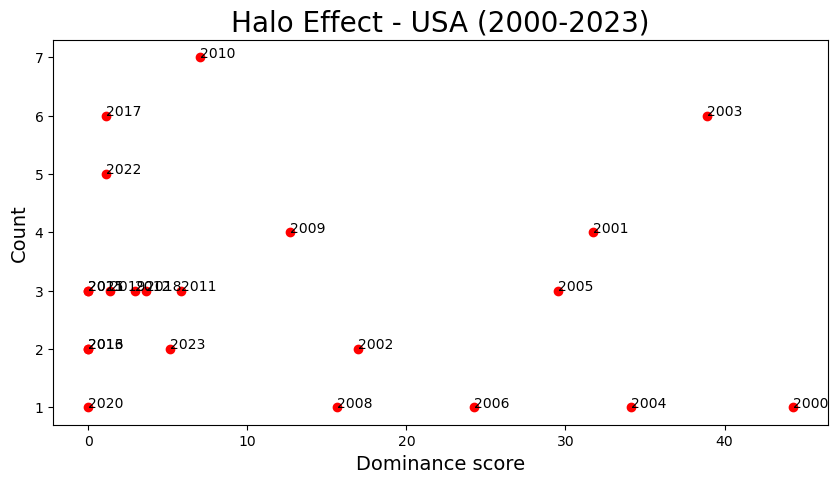

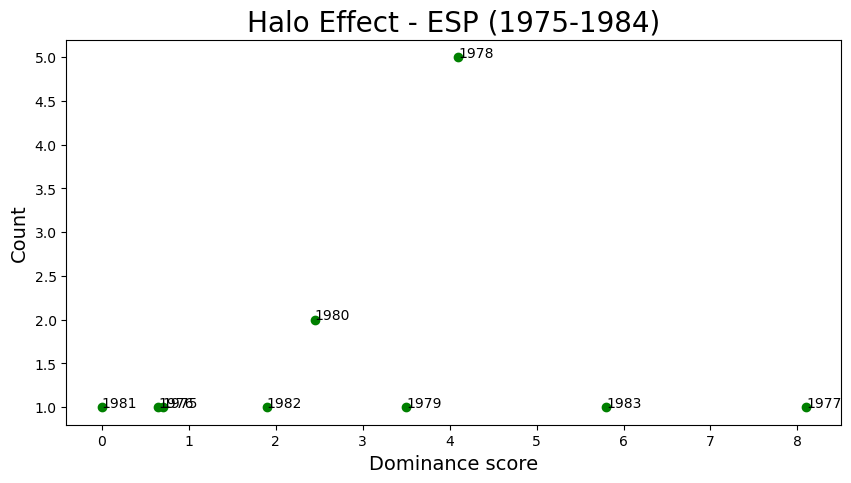

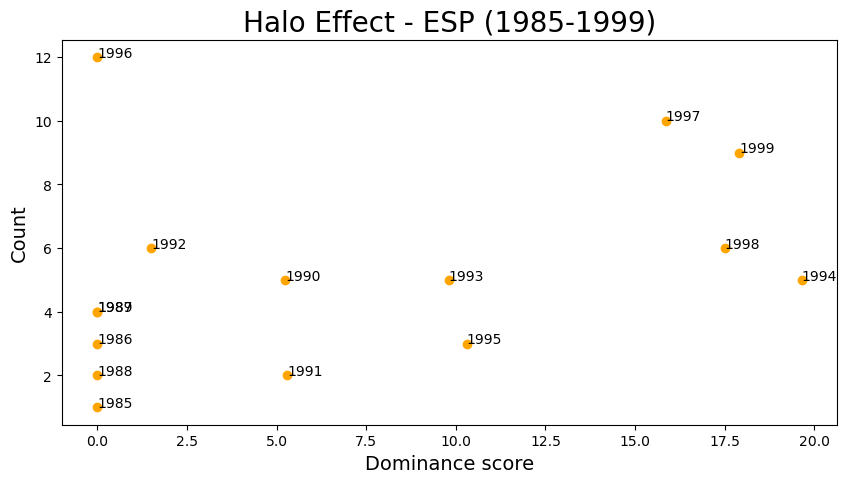

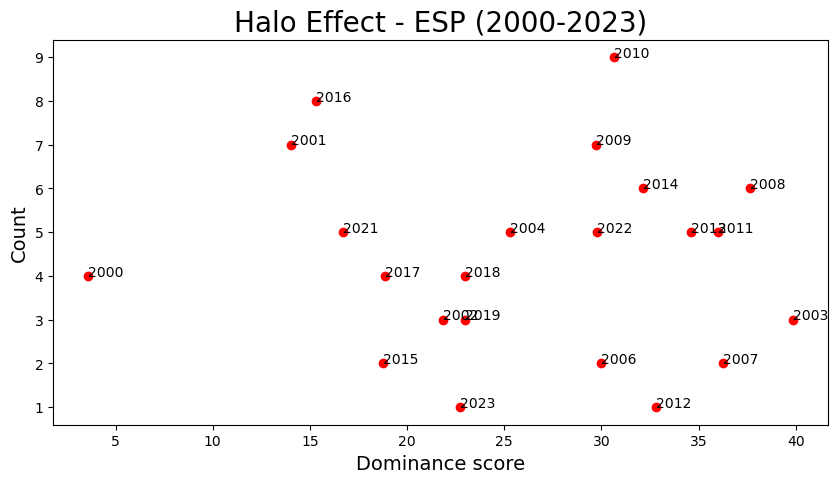

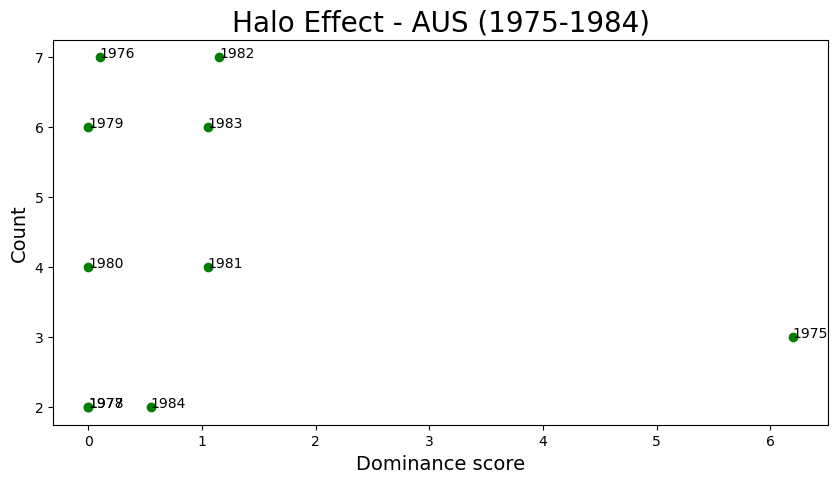

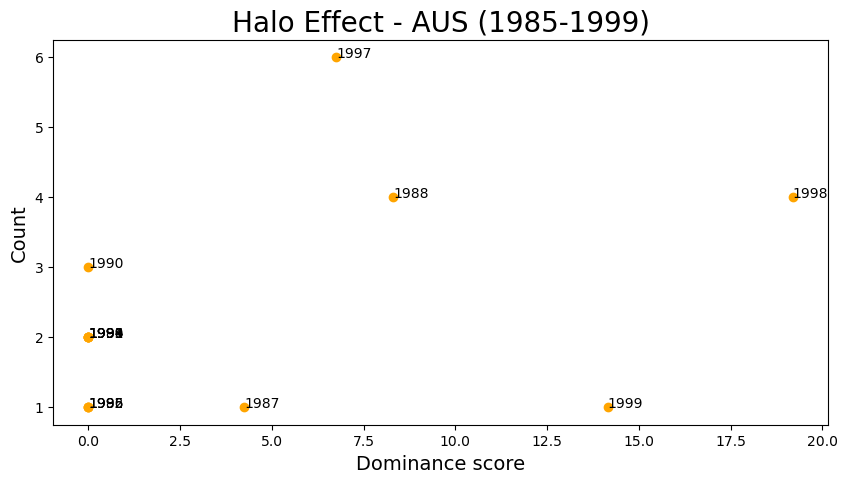

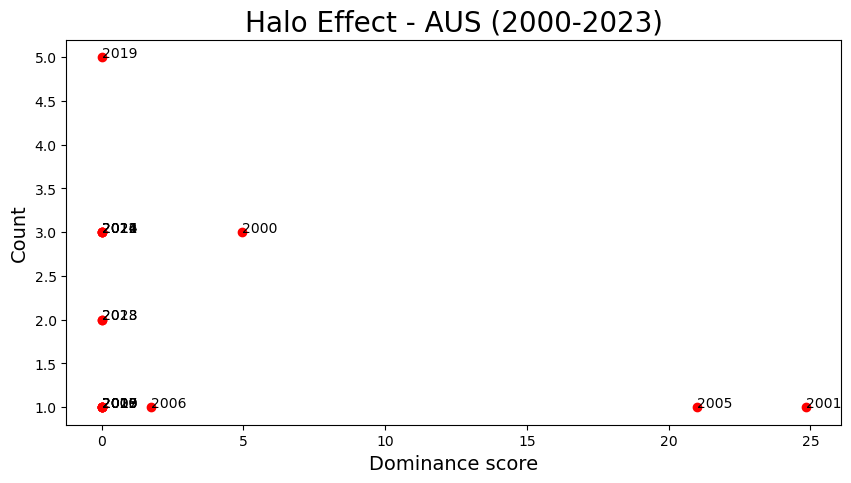

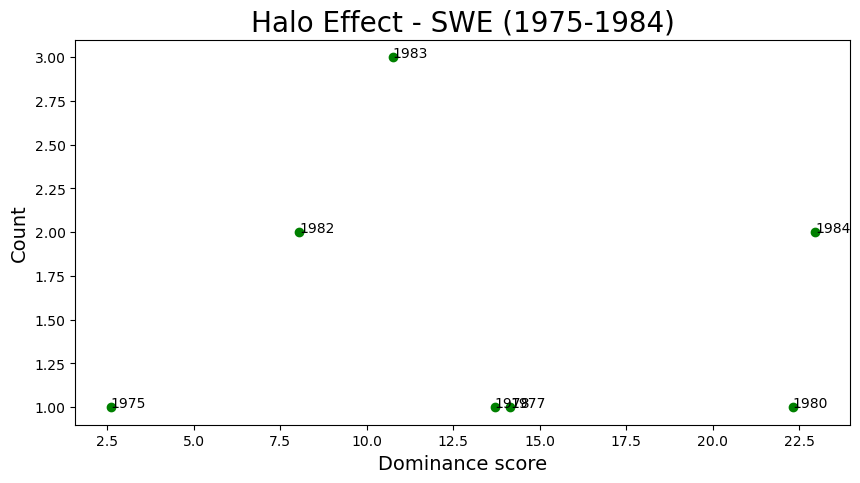

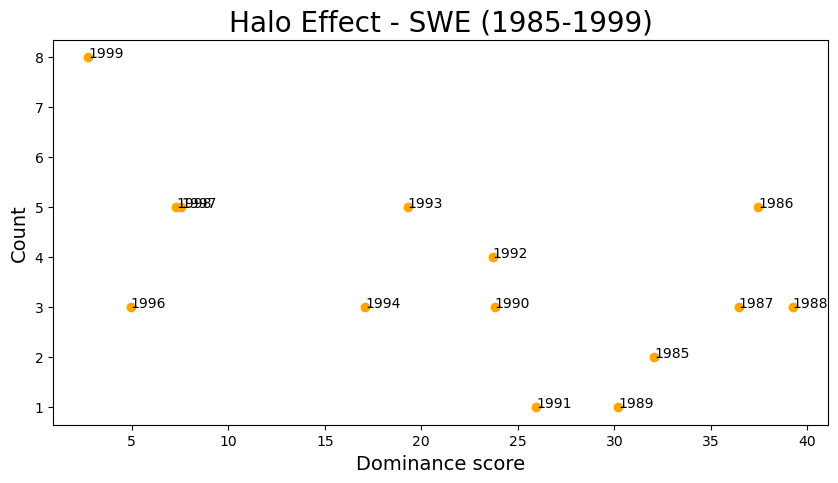

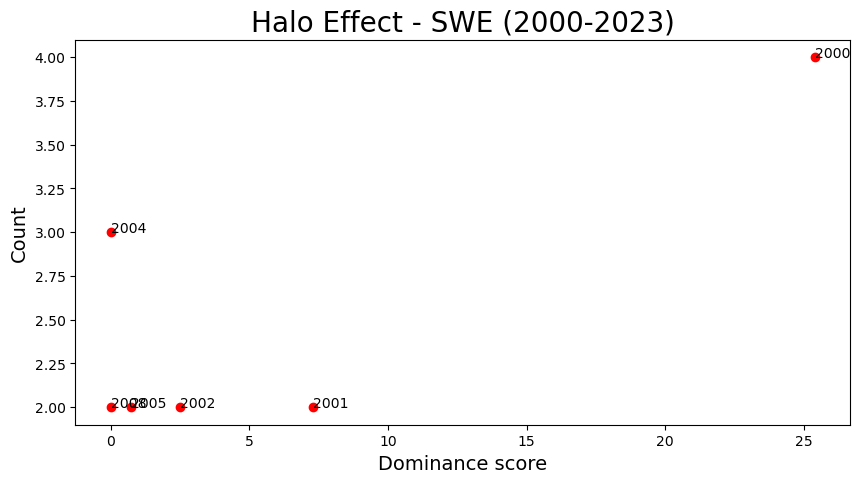

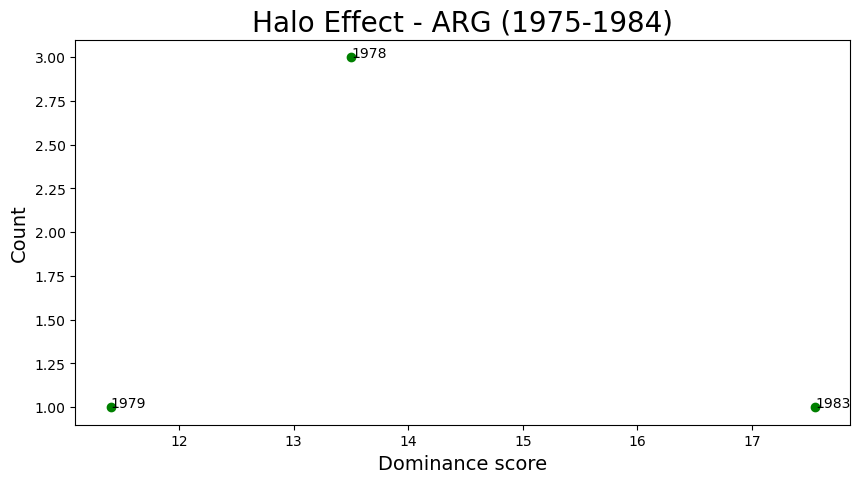

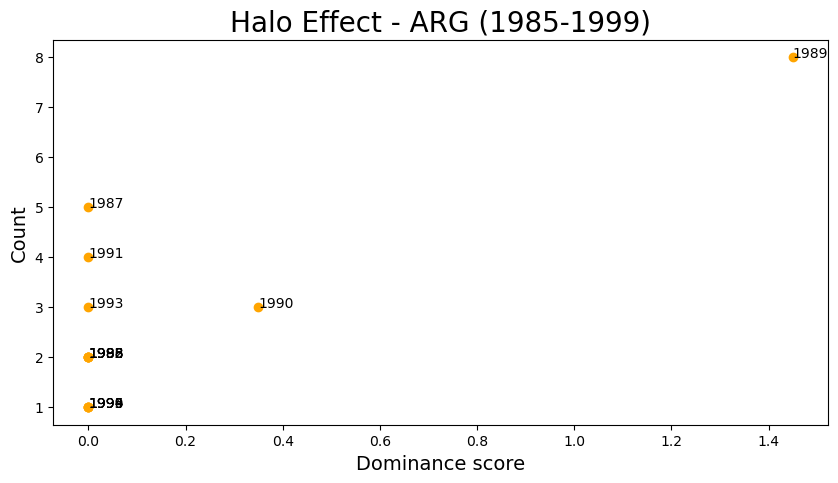

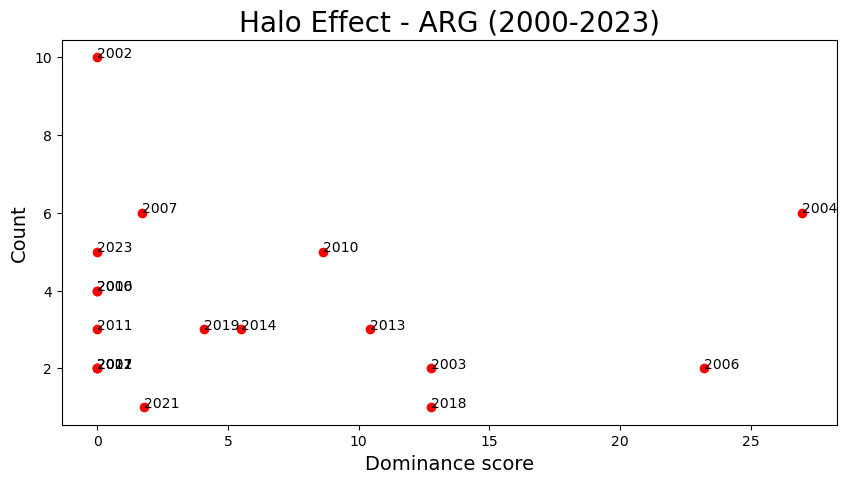

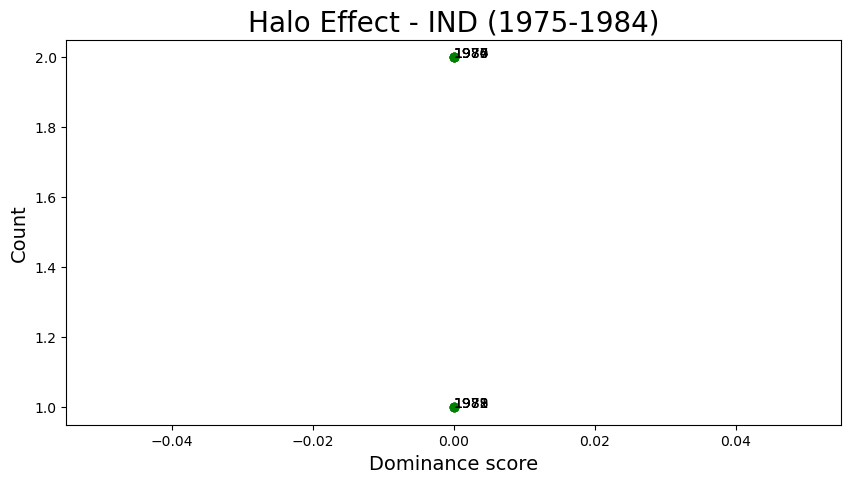

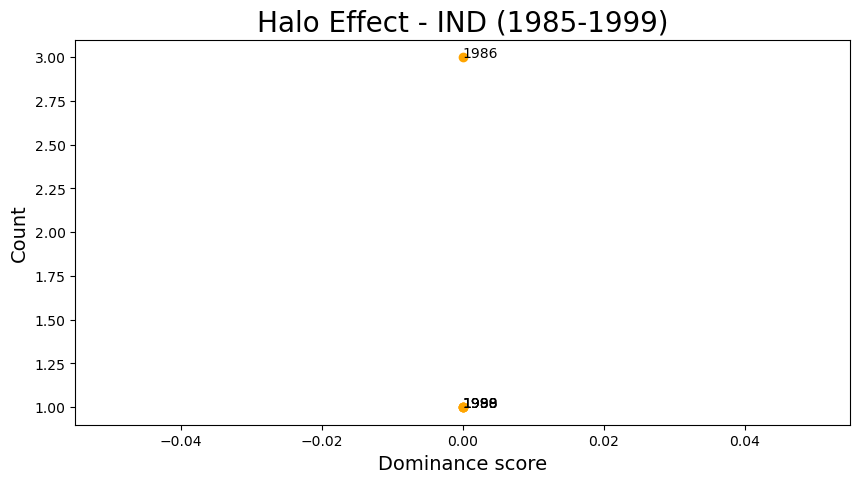

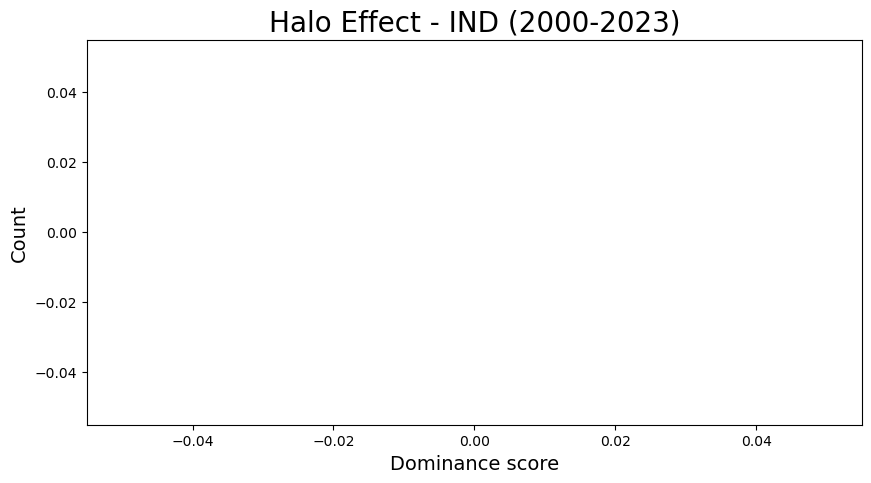

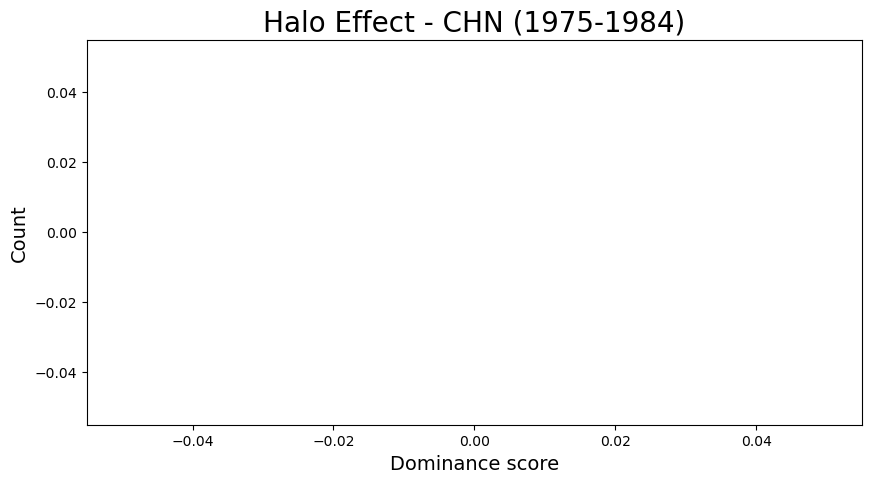

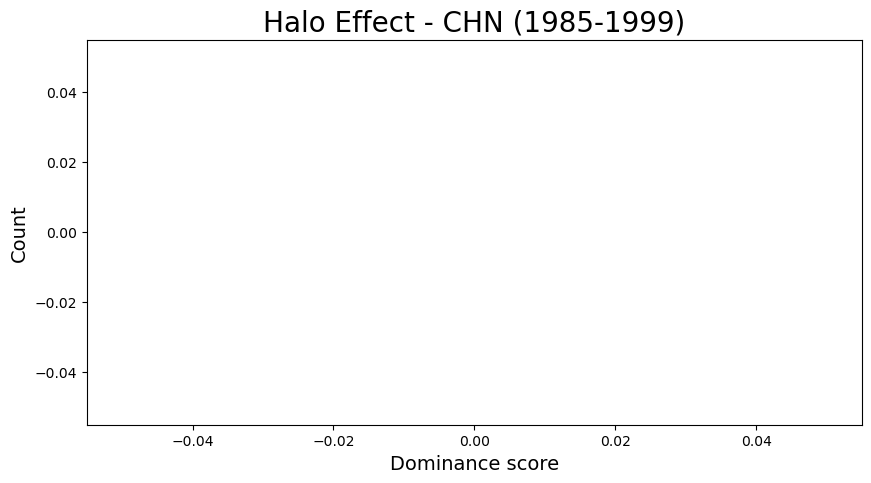

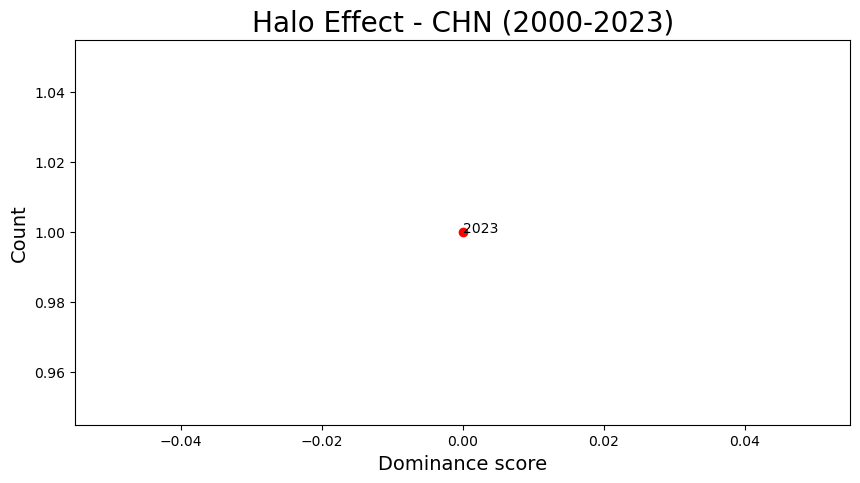

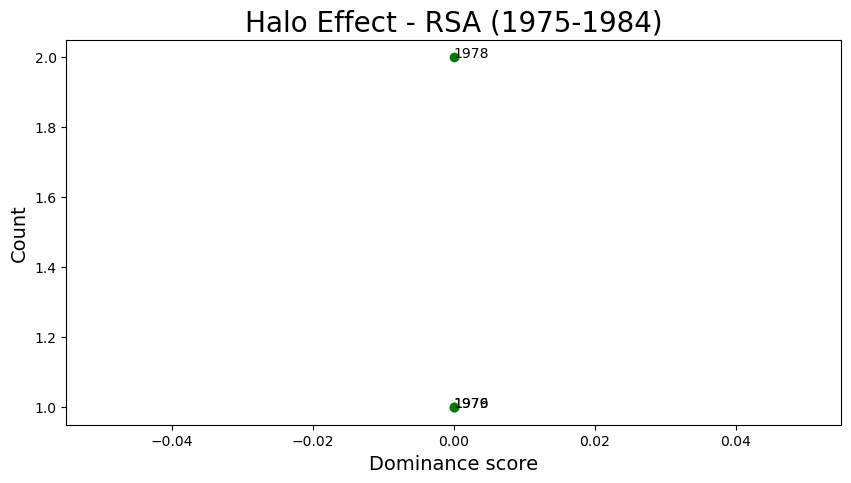

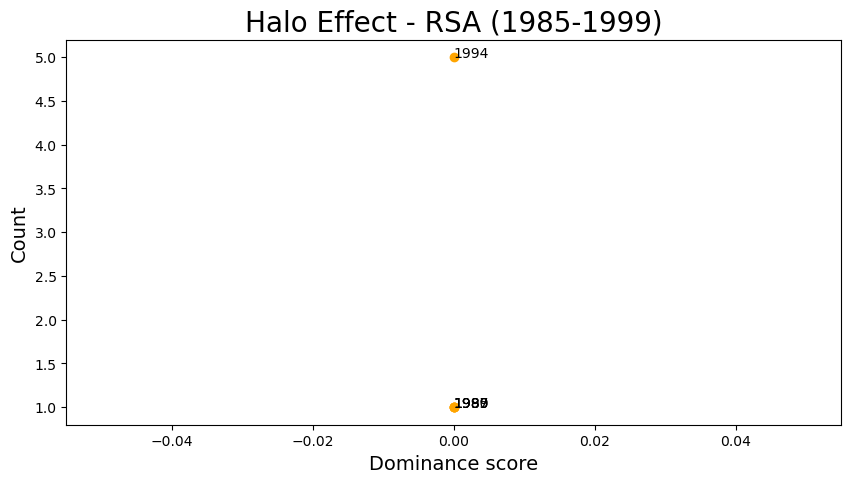

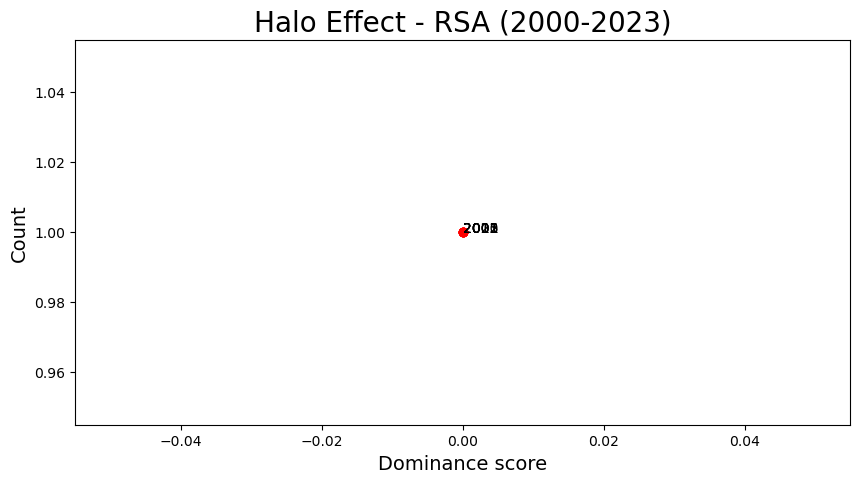

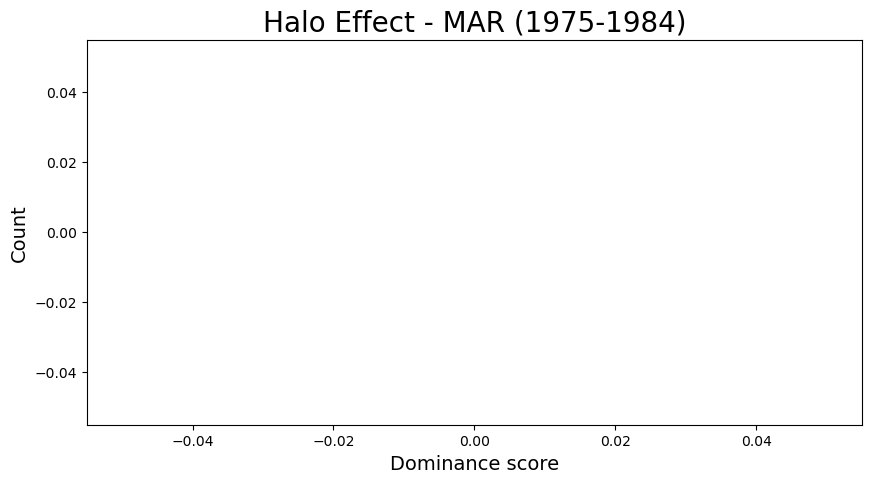

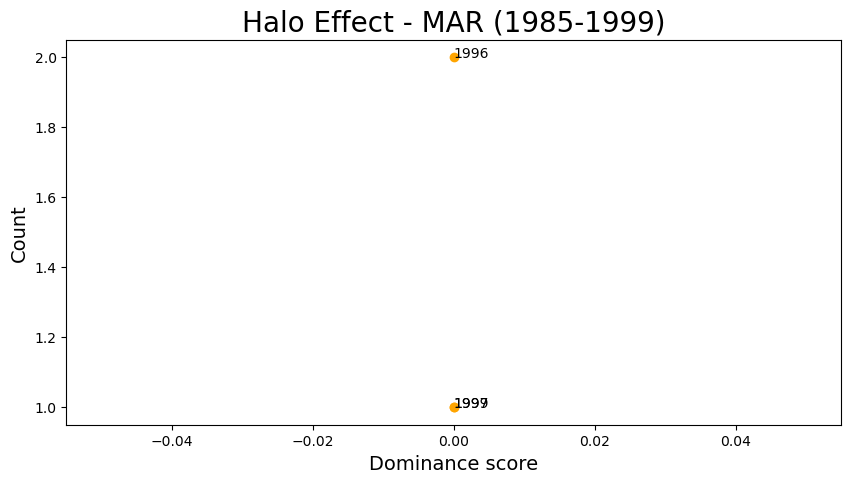

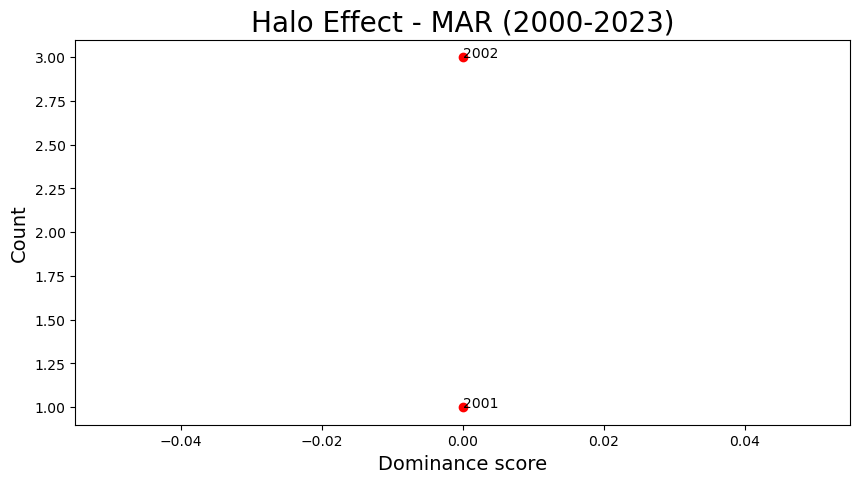

In [5123]:
year_boundaries = [(1975, 1984), (1985, 1999), (2000, 2023)]  # Define your custom year boundaries
colors = ['green', 'orange', 'red']  # Define corresponding colors for each period

for country in countries_of_interest:
    chart_dominance_with_boundaries(country, 10, year_boundaries, colors)
    

/var/folders/pc/d4jq7b1522b7sxkg3p93hs3r0000gn/T/ipykernel_30229/1799597918.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/pc/d4jq7b1522b7sxkg3p93hs3r0000gn/T/ipykernel_30229/1799597918.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



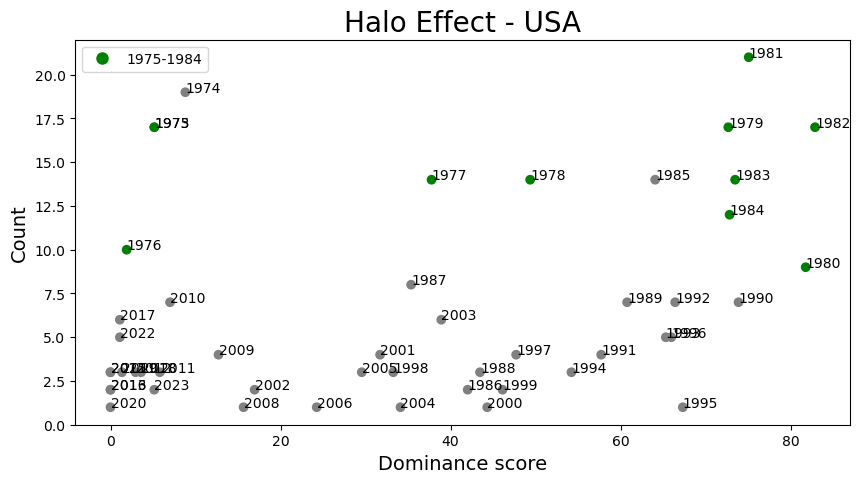

In [5119]:
year_boundaries = [(1975, 1984)]  # Define your custom year boundaries
colors = ['green']  # Define corresponding colors for each period

chart_dominance_with_boundaries('USA', 10, year_boundaries, colors)

In [4175]:
# a  = df_full.groupby('pair').size().reset_index(name='count')
# test= pd.DataFrame(a)
# test.sort_values(by=['count'], ascending=False)

pairs = df_full[['pair','winner_id','season']].sort_values(by=['pair','season'])
pairs

,pair,winner_id,season
51695,"(100001, 100039)",100001,1968
51677,"(100001, 100073)",100073,1968
127815,"(100001, 100074)",100074,1970
49490,"(100001, 100119)",100119,1969
105089,"(100001, 100324)",100324,1977
...,...,...,...
135423,"(211306, 211376)",211376,1972
135438,"(211374, 211384)",211374,1972
53658,"(212421, 212425)",212421,1968
4198,"(212719, 212720)",212720,2024


In [5196]:
pairs_counts_min_max_season = pairs.groupby('pair').agg({'winner_id':'count','season':['max','min']}).reset_index()
#pairs_counts_min_max_season.columns = [col[0] if (len(col) == 1 and isinstance(col,tuple)) else '_'.join(col).strip() if isinstance(col,tuple) else col for col in pairs_counts_min_max_season.columns]
pairs_counts_min_max_season.columns = [col[0] if col[1] == ''  else  col[1] if col[0] == 'winner_id' else '_'.join(col).strip() for col in pairs_counts_min_max_season.columns]
pairs_counts_min_max_season_t20 = pairs_counts_min_max_season.sort_values(by=['count'],ascending=False).reset_index()

In [5198]:
 pairs_counts_min_max_season.sort_values(by=['count'],ascending=False).reset_index()

,index,pair,count,season_max,season_min
0,94136,"(104745, 104925)",59,2022,2006
1,84759,"(103819, 104925)",51,2020,2006
2,84747,"(103819, 104745)",41,2019,2004
3,95427,"(104918, 104925)",37,2022,2006
4,36451,"(100581, 100656)",36,1992,1980
...,...,...,...,...,...
109931,43164,"(100829, 107228)",1,1986,1986
109932,43163,"(100829, 102358)",1,1991,1991
109933,43161,"(100829, 101989)",1,1993,1993
109934,43160,"(100829, 101924)",1,1990,1990


In [5200]:
pairs_counts_min_max_season.sort_values(by=['count'],ascending=True).reset_index()

,index,pair,count,season_max,season_min
0,0,"(100001, 100039)",1,1968,1968
1,66442,"(102087, 102106)",1,2001,2001
2,66441,"(102087, 102097)",1,1996,1996
3,66440,"(102086, 103498)",1,2000,2000
4,66439,"(102086, 102880)",1,1999,1999
...,...,...,...,...,...
109931,36451,"(100581, 100656)",36,1992,1980
109932,95427,"(104918, 104925)",37,2022,2006
109933,84747,"(103819, 104745)",41,2019,2004
109934,84759,"(103819, 104925)",51,2020,2006


In [5202]:
df_top20_rivalries = df_full[df_full['pair'].isin(pairs_counts_min_max_season_t20.reset_index()['pair'])]

In [5205]:
df_riv_won = df_top20_rivalries.groupby(['pair','winner_id']).size().reset_index(name='count')
df_riv_won_1row = df_riv_won[df_riv_won['pair'].apply(lambda x: x[0]) ==  df_riv_won['winner_id']]

In [5207]:
pairs_counts_min_max_season_t20

,index,pair,count,season_max,season_min
0,94136,"(104745, 104925)",59,2022,2006
1,84759,"(103819, 104925)",51,2020,2006
2,84747,"(103819, 104745)",41,2019,2004
3,95427,"(104918, 104925)",37,2022,2006
4,36451,"(100581, 100656)",36,1992,1980
...,...,...,...,...,...
109931,43164,"(100829, 107228)",1,1986,1986
109932,43163,"(100829, 102358)",1,1991,1991
109933,43161,"(100829, 101989)",1,1993,1993
109934,43160,"(100829, 101924)",1,1990,1990


In [5209]:
df_riv_won_1row[df_riv_won_1row['pair'] == (104745, 104925)]

,pair,winner_id,count
111925,"(104745, 104925)",104745,29


In [5211]:
pairs_counts_min_max_season[pairs_counts_min_max_season['pair'] == (104745, 104925)]

,pair,count,season_max,season_min
94136,"(104745, 104925)",59,2022,2006


In [5213]:
df_riv_stats = pairs_counts_min_max_season_t20.merge(df_riv_won_1row, how='left', on = 'pair')

In [5215]:
df_riv_stats[(df_riv_stats['pair'] ==  (104745, 104925)) & (df_riv_stats['winner_id'] == 104745) ]

,index,pair,count_x,season_max,season_min,winner_id,count_y
0,94136,"(104745, 104925)",59,2022,2006,104745.0,29.0


In [5217]:
df_riv_temp = df_riv_stats.rename(columns = {'count_x': 'total_matchups','winner_id':'player_1','count_y': 'player_1_wins'})

In [5219]:
df_riv_temp['player_2'] =  df_riv_temp['pair'].apply(lambda x: x[1])

In [5221]:
df_riv_temp['player_2_wins'] = df_riv_temp['total_matchups'] - df_riv_temp['player_1_wins']

In [5223]:
players['cool_name'] = players['name_first'].apply(lambda x: f'{x[0]}. ' if isinstance(x,str) else '' ) + players['name_last'] + ' (' + players['ioc'] + ')'

In [5225]:
df_riv_temp  = df_riv_temp.merge(players[['player_id','cool_name']], how='left',  left_on='player_1', right_on = 'player_id').rename(columns={'cool_name': 'player_1_name'})

In [5227]:
df_riv_temp  = df_riv_temp.merge(players[['player_id','cool_name']], how='left',  left_on='player_2', right_on = 'player_id').rename(columns={'cool_name': 'player_2_name'})

In [5229]:
#df_riv_temp
df_riv_final = df_riv_temp.drop(columns=['index','player_id_x','player_id_y'])

In [5231]:
df_riv_tt = df_riv_final.iloc[:]

In [5233]:
df_riv_tt.shape

(109936, 10)

In [5235]:
df_riv_tt['season_max'] - df_riv_tt['season_min'] 

0         16
1         14
2         15
3         16
4         12
          ..
109931     0
109932     0
109933     0
109934     0
109935     0
Length: 109936, dtype: int64

In [5237]:
df_riv_tt['heat_index'] = (df_riv_tt['season_max'] - df_riv_tt['season_min']) / abs((df_riv_tt['player_1_wins'] - df_riv_tt['player_2_wins'])/df_riv_tt['total_matchups'])

In [5240]:
df_temp1=df_riv_tt.sort_values(by=['heat_index'], ascending=False)[['player_1_name','player_2_name','heat_index']]
df_temp1.pivot(index='player_1_name',columns='player_2_name',values='heat_index')

ValueError: Index contains duplicate entries, cannot reshape

In [5245]:
df_temp1=df_temp1.reset_index().drop(columns=['index'])

In [5247]:
df_temp1 = df_temp1.pivot(index='player_1_name',columns='player_2_name',values='heat_index')

ValueError: Index contains duplicate entries, cannot reshape

In [5249]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_temp1, annot=True, cmap="YlOrRd", linewidths=0.5, linecolor='black', cbar_kws={'label': 'Heat Index'}, fmt=".0f")

# Customize the visual
plt.title("Rivalry Heatmap Between Players", fontsize=18, pad=20)
plt.xlabel("Player 2", fontsize=14)
plt.ylabel("Player 1", fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

ValueError: could not convert string to float: 'D. Tursunov (RUS)'

<Figure size 1000x800 with 0 Axes>

In [5251]:
df_riv_tt.head()

,pair,total_matchups,season_max,season_min,player_1,player_1_wins,player_2,player_2_wins,player_1_name,player_2_name,heat_index
0,"(104745, 104925)",59,2022,2006,104745.0,29.0,104925,30.0,R. Nadal (ESP),N. Djokovic (SRB),944.000000
1,"(103819, 104925)",51,2020,2006,103819.0,23.0,104925,28.0,R. Federer (SUI),N. Djokovic (SRB),142.800000
2,"(103819, 104745)",41,2019,2004,103819.0,17.0,104745,24.0,R. Federer (SUI),R. Nadal (ESP),87.857143
3,"(104918, 104925)",37,2022,2006,104918.0,11.0,104925,26.0,A. Murray (GBR),N. Djokovic (SRB),39.466667
4,"(100581, 100656)",36,1992,1980,100581.0,15.0,100656,21.0,J. McEnroe (USA),I. Lendl (USA),72.000000


In [5253]:
df_riv_tt['heat_index2'] = (1-(abs((df_riv_tt['player_1_wins'] - df_riv_tt['player_2_wins'])/df_riv_tt['total_matchups']) * ((df_riv_tt['season_max'] - df_riv_tt['season_min'] )/55))) * 100

In [5275]:
df_temp_recreate = df_riv_tt

In [5257]:
df_temp2['player_1_name_fixed'], df_temp2['player_2_name_fixed'] = zip(*df_temp2.apply(
    lambda row: sorted([row['player_1_name'], row['player_2_name']]), axis=1))

df_temp2 = df_temp2.drop(columns=['player_1_name', 'player_2_name'])

df_temp2.rename(columns={'player_1_name_fixed': 'player_1_name', 'player_2_name_fixed': 'player_2_name'}, inplace=True)


In [5267]:
df_temp3 = df_temp2.pivot(index='player_1_name', columns='player_2_name', values='heat_index2')


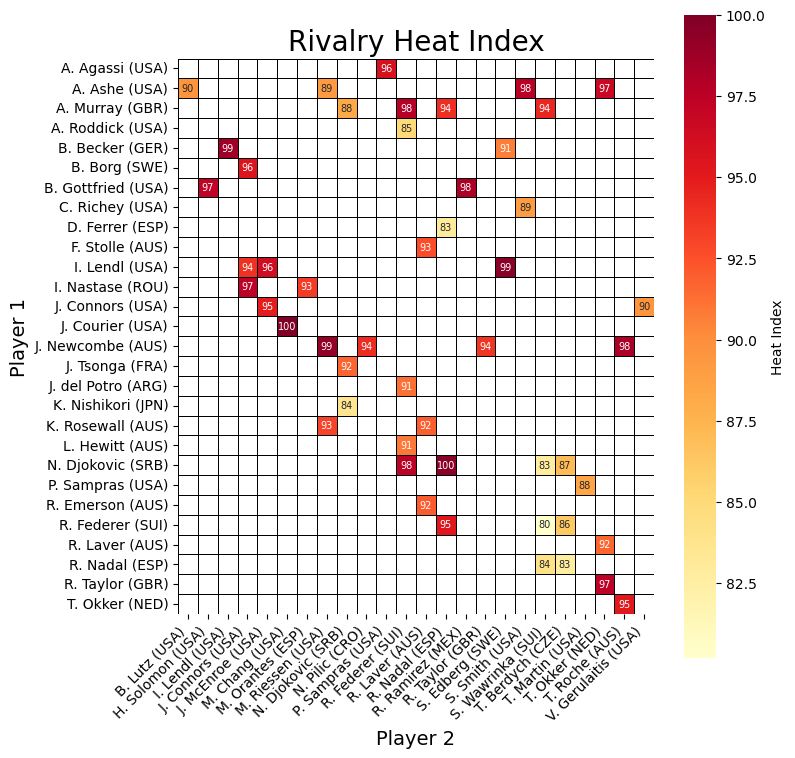

In [4242]:
plt.figure(figsize=(8, 8))
sns.heatmap(df_temp3, annot=True, cmap="YlOrRd", linewidths=0.5, linecolor='black', cbar_kws={'label': 'Heat Index'}, fmt=".0f",
           annot_kws={"size": 7, "ha": 'center', "va": 'center'}, 
           square=True,
           )

# Customize the visual
plt.title("Rivalry Heat Index", fontsize=20)
plt.xlabel("Player 2", fontsize=14)
plt.ylabel("Player 1", fontsize=14)
plt.xticks(rotation=45,ha='right')
plt.tight_layout()

plt.savefig('HeatIndex.png',format='png')
plt.show()

In [4245]:
df_winner_span = df_full.groupby('winner_id').agg({'tourney_date':['min','max']}).reset_index()
df_loser_span = df_full.groupby('loser_id').agg({'tourney_date':['min','max']}).reset_index()
df_loser_span.columns  = ['_'.join(col).strip() if isinstance(col,tuple) else col  for col in df_loser_span.columns]
df_winner_span.columns = ['_'.join(col).strip() if isinstance(col,tuple) else col  for col in df_winner_span.columns]
df_winner_span = df_winner_span.rename(columns={'winner_id_':'player_id'})
df_loser_span = df_loser_span.rename(columns={'loser_id_':'player_id'})

In [4247]:
df_loser_span.shape

(7382, 3)

In [4249]:
df_winner_span.shape

(4341, 3)

In [4251]:
df_player_span_tmp = pd.concat([df_winner_span,df_loser_span]).drop_duplicates()

In [4253]:
df_player_span_tmp2 = df_player_span_tmp.groupby('player_id').agg({'tourney_date_min':'min','tourney_date_max': 'max'}).reset_index()

In [4255]:
df_player_span_fnl = df_player_span_tmp2.merge(players, how='left', on='player_id')

In [4257]:
df_player_span_fnl['last_game_age'] = (pd.to_datetime(df_player_span_fnl['tourney_date_max'], format='%Y%m%d') - pd.to_datetime(df_player_span_fnl['dob'], format='%Y%m%d')).dt.days / 365.25

In [4259]:
pd.to_datetime(df_player_span_fnl['dob'],format='%Y%m%d').dt.year

0       1913.0
1       1921.0
2       1927.0
3       1927.0
4       1928.0
         ...  
7520    1997.0
7521    1996.0
7522    2005.0
7523    2005.0
7524    2005.0
Name: dob, Length: 7525, dtype: float64

In [4261]:
bins = [1899, 1927, 1945, 1964, 1980, 1996, 2012, 2025]  
labels = [
    'Pre Silent Generation (1900-1927)',
    'Silent Generation (1928-1945)', 
    'Baby Boomers (1946-1964)', 
    'Generation X (1965-1980)', 
    'Millennials (1981-1996)', 
    'Generation Z (1997-2012)', 
    'Generation Alpha (2013-2025)'
]
df_player_span_fnl['generation'] = pd.cut(pd.to_datetime(df_player_span_fnl['dob'],format='%Y%m%d').dt.year, bins=bins, labels=labels)

In [4263]:
#df_player_span_fnl[df_player_span_fnl['last_game_age'].isnull()] #rows dropped as dob is unknown
df_player_span_fnl[df_player_span_fnl['last_game_age'] < 0 ] #rows dropped as dob is unknown

,player_id,tourney_date_min,tourney_date_max,name_first,name_last,hand,dob,ioc,height,wikidata_id,cool_name,last_game_age,generation
2194,103616,19680101,19720801,Andre,Van Der Merwe B,R,19800815.0,RSA,NaN,NaN,A. Van Der Merwe B (RSA),-8.038330,Generation X (1965-1980)
2526,104418,19701219,19701219,Matthew,Smith,R,19840821.0,GBR,NaN,NaN,M. Smith (GBR),-13.672827,Millennials (1981-1996)
2696,104828,19691111,19691111,Alejandro,Kon,U,19861110.0,ARG,NaN,NaN,A. Kon (ARG),-16.996578,Millennials (1981-1996)
3051,105866,19840504,19840504,Joao,Maio,R,19911102.0,POR,NaN,NaN,J. Maio (POR),-7.496235,Millennials (1981-1996)
3068,105914,19690414,19690428,Ashley,Hewitt,R,19920206.0,GBR,NaN,NaN,A. Hewitt (GBR),-22.776181,Millennials (1981-1996)
3265,106564,19690528,19690528,Anton,Ivanov,R,19700118.0,UZB,NaN,NaN,A. Ivanov (UZB),-0.643395,Generation X (1965-1980)
4325,109150,19681123,19681123,David,Wright,R,19800124.0,ECU,NaN,NaN,D. Wright (ECU),-11.167693,Generation X (1965-1980)
4328,109262,19700406,19700406,Milan,Vopicka,R,19760325.0,CZE,NaN,NaN,M. Vopicka (CZE),-5.968515,Generation X (1965-1980)
4792,110268,19680415,19701003,Ernesto,Aguirre,U,20000101.0,CHI,NaN,Q28518890,E. Aguirre (CHI),-29.245722,Generation Z (1997-2012)
5533,120389,19700316,19700316,Juan,Fernandez,U,19740312.0,ARG,NaN,NaN,J. Fernandez (ARG),-3.989049,Generation X (1965-1980)


In [4265]:
df_player_span_fnl = df_player_span_fnl.dropna(subset=['last_game_age'])

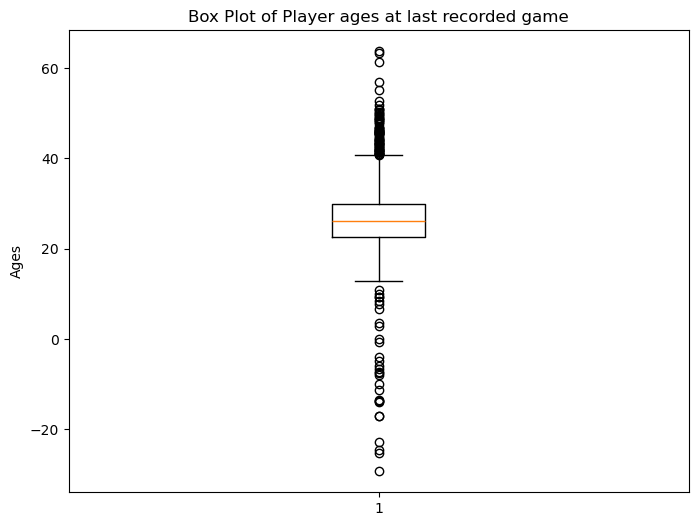

In [4267]:
df_player_span_fnl['last_game_age'] = pd.to_numeric(df_player_span_fnl['last_game_age'], errors='coerce')

plt.figure(figsize=(8, 6))  # Optional, to control figure size
plt.boxplot(df_player_span_fnl['last_game_age'])

# Customize the plot
plt.title('Box Plot of Player ages at last recorded game')
plt.ylabel('Ages')

# Show the plot
plt.show()

In [4269]:
df_player_span_fnl['last_game_age']

0       63.211499
1       52.700890
2       48.605065
3       45.642710
4       45.357974
          ...    
7520    26.847365
7521    27.288159
7522    18.376454
7523    18.710472
7524    18.551677
Name: last_game_age, Length: 5443, dtype: float64

In [4271]:
df_full[df_full['winner_id'] == 103616]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,season,pair
51405,1968-260,Durban 1,Hard,64.0,A,19680114,240,103616,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968,"(103616, 209625)"
53819,1968-9346,Cape Town,NaN,NaN,A,19680101,152,103616,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1968,"(103616, 212436)"
135496,1972-317,Hilversum,Hard,64.0,A,19720801,246,103616,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1972,"(103616, 211441)"
135595,1972-426,Johannesburg,Hard,32.0,A,19720408,205,103616,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1972,"(100327, 103616)"


In [4273]:
players[players['player_id'] == 103616]

,player_id,name_first,name_last,hand,dob,ioc,height,wikidata_id,cool_name
3615,103616,Andre,Van Der Merwe B,R,19800815.0,RSA,NaN,NaN,A. Van Der Merwe B (RSA)


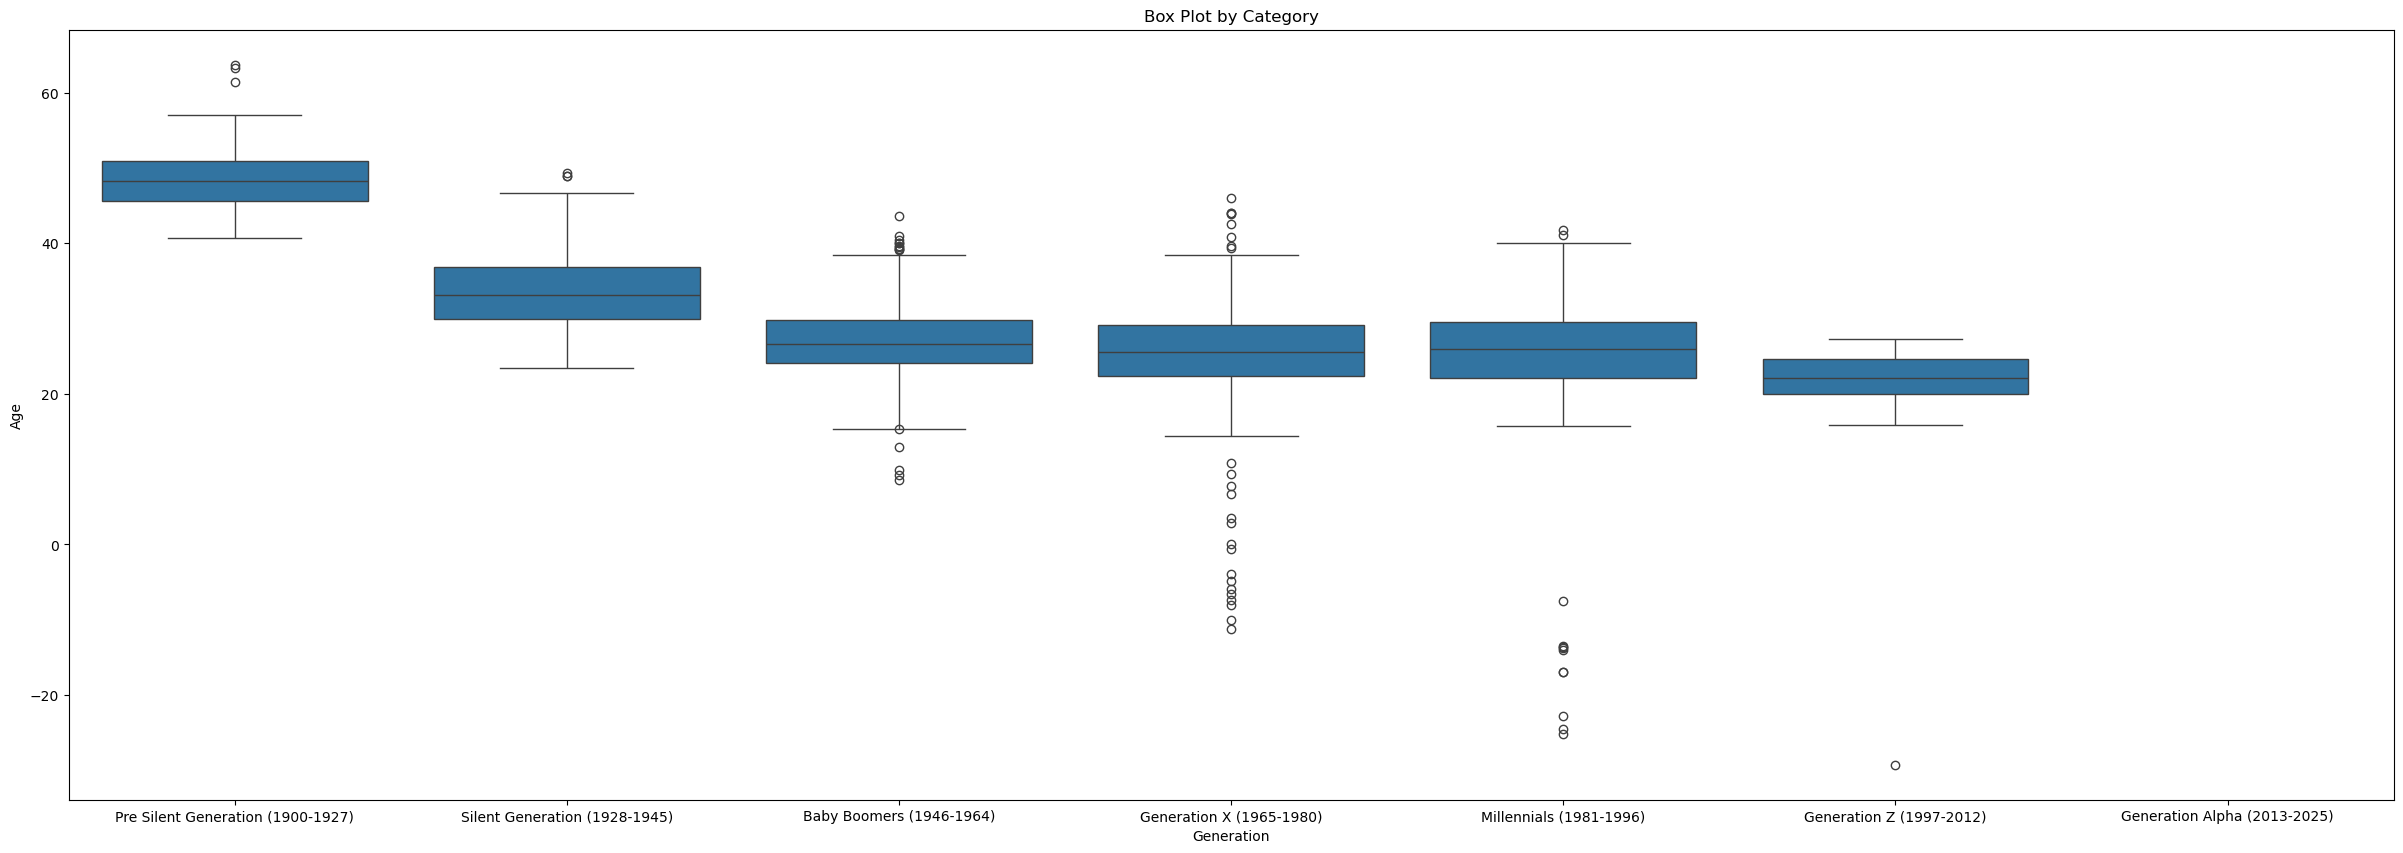

In [4275]:
plt.figure(figsize=(30, 10))  # Optional, to control figure size
sns.boxplot(x='generation', y='last_game_age', data=df_player_span_fnl)

# Customize the plot
plt.title('Box Plot by Category')
plt.xlabel('Generation')
plt.ylabel('Age')

# Show the plot
plt.show()

In [4277]:
df_player_span_fnl[df_player_span_fnl['generation'] == 'Generation Alpha (2013-2025)']

,player_id,tourney_date_min,tourney_date_max,name_first,name_last,hand,dob,ioc,height,wikidata_id,cool_name,last_game_age,generation


In [4279]:
df_player_span_fnl['generation'].value_counts()

generation
Generation X (1965-1980)             1709
Millennials (1981-1996)              1449
Baby Boomers (1946-1964)             1414
Generation Z (1997-2012)              447
Silent Generation (1928-1945)         390
Pre Silent Generation (1900-1927)      34
Generation Alpha (2013-2025)            0
Name: count, dtype: int64

In [4281]:
df_riv_tt.sort_values(by=['heat_index2'])

,pair,total_matchups,season_max,season_min,player_1,player_1_wins,player_2,player_2_wins,player_1_name,player_2_name,heat_index,heat_index2


In [4283]:
df_full.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points',
       'season', 'pair'],
      dtype='object')

In [4285]:
df_full['round'] #.drop_duplicates().sort_values()

0          F
1         SF
2         SF
3         QF
4         QF
          ..
193332    SF
193333     F
193334    RR
193335    RR
193336    RR
Name: round, Length: 193337, dtype: object

## Define eras in tennis

In [4290]:
era = df_full[df_full['winner_id'].isin(df_tourney_winners_sans_dc_count.head(40)['winner_id'])].groupby('winner_id').agg({'season':['min','max']}).reset_index()
era.columns = [ col[0]  if col[1] == ''  else '_'.join(col).strip() for col in era.columns]
df_winners_eras = df_tourney_winners_sans_dc_count.head(40).merge(era, on='winner_id', how='left')

In [4292]:
df_winners_eras['era_mid']= dr_winners_eras.apply(lambda row: int(row['season_min'] + ((row['season_max'] - row['season_min'])/2)), axis =1)

In [4294]:
df_winners_eras.sort_values(by='era_mid')

,winner_id,winner_name,winner_ioc,count,season_min,season_max,era_mid
33,100128,Cliff Richey,USA,23,1968,1978,1973
6,100029,Rod Laver,AUS,72,1968,1978,1973
14,100074,Arthur Ashe,USA,49,1968,1979,1973
18,100087,John Newcombe,AUS,41,1968,1979,1973
19,100016,Ken Rosewall,AUS,40,1968,1980,1974
21,100084,Tom Okker,NED,37,1968,1981,1974
12,100126,Stan Smith,USA,52,1968,1983,1975
20,100174,Manuel Orantes,ESP,39,1968,1983,1975
8,100119,Ilie Nastase,ROU,66,1968,1985,1976
36,100232,Eddie Dibbs,USA,22,1970,1984,1977


In [4296]:
df_full

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,season,pair
0,2019-M020,Brisbane,Hard,32.0,A,20181231,300,105453,2.0,NaN,...,20.0,14.0,10.0,15.0,9.0,3590.0,16.0,1977.0,2019,"(105453, 106421)"
1,2019-M020,Brisbane,Hard,32.0,A,20181231,299,106421,4.0,NaN,...,7.0,10.0,10.0,13.0,16.0,1977.0,239.0,200.0,2019,"(104542, 106421)"
2,2019-M020,Brisbane,Hard,32.0,A,20181231,298,105453,2.0,NaN,...,6.0,8.0,1.0,5.0,9.0,3590.0,40.0,1050.0,2019,"(104871, 105453)"
3,2019-M020,Brisbane,Hard,32.0,A,20181231,297,104542,NaN,PR,...,9.0,11.0,4.0,6.0,239.0,200.0,31.0,1298.0,2019,"(104542, 200282)"
4,2019-M020,Brisbane,Hard,32.0,A,20181231,296,106421,4.0,NaN,...,19.0,15.0,2.0,4.0,16.0,1977.0,18.0,1855.0,2019,"(105683, 106421)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193332,2014-605,Tour Finals,Hard,8.0,F,20141109,514,104925,1.0,NaN,...,5.0,11.0,3.0,9.0,1.0,10010.0,5.0,4625.0,2014,"(104925, 105453)"
193333,2014-605,Tour Finals,Hard,8.0,F,20141109,515,104925,1.0,NaN,...,NaN,NaN,NaN,NaN,1.0,10010.0,2.0,8700.0,2014,"(103819, 104925)"
193334,2014-D015,Davis Cup WG F: FRA vs SUI,Clay,4.0,D,20141121,1,104527,NaN,NaN,...,NaN,NaN,NaN,NaN,4.0,5295.0,12.0,2740.0,2014,"(104527, 104542)"
193335,2014-D015,Davis Cup WG F: FRA vs SUI,Clay,4.0,D,20141121,2,104792,NaN,NaN,...,NaN,NaN,NaN,NaN,19.0,1825.0,2.0,9700.0,2014,"(103819, 104792)"


In [4298]:
players[players['name_last'] == 'Chang']
#102021

,player_id,name_first,name_last,hand,dob,ioc,height,wikidata_id,cool_name
1572,101573,Carl,Chang,R,19690213.0,USA,175.0,Q5039980,C. Chang (USA)
1589,101590,Eui Jong,Chang,R,19690401.0,KOR,183.0,Q5071607,E. Chang (KOR)
1864,101865,Albert,Chang,R,19710227.0,CAN,183.0,Q4709909,A. Chang (CAN)
2020,102021,Michael,Chang,R,19720222.0,USA,175.0,Q53370,M. Chang (USA)
4634,104636,Yao Lun,Chang,R,19851114.0,TPE,NaN,NaN,Y. Chang (TPE)
4976,104982,Huai En,Chang,R,19870723.0,TPE,NaN,NaN,H. Chang (TPE)
5194,105202,Yu,Chang,U,19880814.0,CHN,NaN,Q8936651,Y. Chang (CHN)
6703,106718,Cheng Fong,Chang,R,19720420.0,CHN,NaN,NaN,C. Chang (CHN)
7462,107477,Kai Lung,Chang,R,NaN,TPE,NaN,NaN,K. Chang (TPE)
8616,108631,Wen Lung,Chang,U,19800710.0,TPE,NaN,NaN,W. Chang (TPE)


In [5340]:
df_nad_djok = df_full[df_full['pair'] == (104745, 104925)]
# 104925 - djokovic
# 104745 - nadal
#Michael Chang = 102021
#Courier = 101793
#Lendl = 100656
#Becker = 101414

#pair = (101793,102021)
#pair = (100656,101414)
df_lendl_beckr = df_full[df_full['pair'] == (100656,101414)]
df_cour_chan = df_full[df_full['pair'] == (101793,102021)]

In [5362]:
df_cour_chan['surface'].value_counts(dropna=False)

surface
Hard      15
Carpet     7
Clay       2
Name: count, dtype: int64

In [4387]:
df_nad_djok.groupby(['winner_name','surface']).agg({'tourney_id':'count'}).reset_index().rename(columns={'tourney_id':'count'})

,winner_id,surface,count
0,104745,Clay,20
1,104745,Grass,2
2,104745,Hard,7
3,104925,Clay,8
4,104925,Grass,2
5,104925,Hard,20


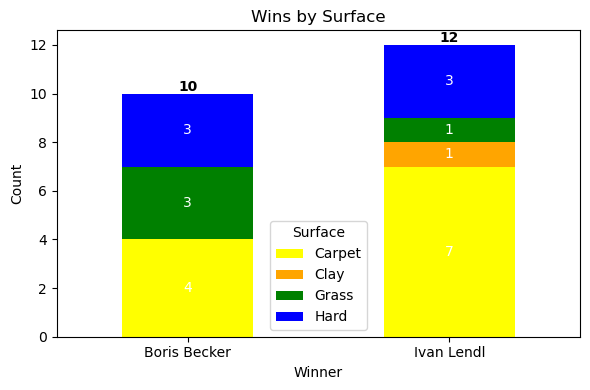

In [5370]:

# Group by winner_name and surface, count the number of tournaments, then pivot
df_pivot = df_lendl_beckr.groupby(['winner_name', 'surface']).agg({'tourney_id': 'count'}).reset_index().rename(columns={'tourney_id': 'count'}).pivot(index='winner_name', columns='surface', values='count')

# Define custom colors for the surfaces
colors = {
    'Grass': 'green',
    'Clay': 'orange',
    'Hard': 'blue',
    'Carpet': 'yellow'
}

missing_surfaces = [surface for surface in df_pivot.columns if surface not in colors]

if missing_surfaces:
    print(f"Missing surface color mappings for: {missing_surfaces}")
else:
    ax = df_pivot.plot(kind='bar', stacked=True, figsize=(6, 4), color=[colors.get(x) for x in df_pivot.columns])

# Plotting the stacked bar chart with custom colors
#ax = df_pivot.plot(kind='bar', stacked=True, figsize=(6, 4), color=[colors.get(x) for x in df_pivot.columns])

# Set plot labels and title
ax.set_xlabel('Winner')
ax.set_ylabel('Count')
ax.set_title('Wins by Surface')

# Add value labels within each stack and the total count on top of each bar
for rect in ax.patches:  # Loop through each bar
    height = rect.get_height()
    if height > 0:  # Only annotate non-zero values
        ax.annotate(f'{int(height)}', 
                    (rect.get_x() + rect.get_width() / 2., rect.get_y() + height / 2.), 
                    ha='center', va='center', color='white')

# Annotate the total count at the top of each stack
totals = df_pivot.sum(axis=1)  # Sum of all surfaces for each winner
for i, total in enumerate(totals):
    ax.annotate(f'{int(total)}', 
                (i, total), 
                ha='center', va='bottom', color='black', fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=0)

# Adjust layout and show the plot
plt.legend(title='Surface')
plt.tight_layout()
plt.show()


In [4546]:
df_nad_djok.groupby(['winner_name','surface']).agg({'w_ace':'sum','l_ace':'sum'})

w_ace  l_ace
winner_name    surface              
Novak Djokovic Clay      25.0   20.0
               Grass     30.0   14.0
               Hard     117.0   56.0
Rafael Nadal   Clay      46.0   65.0
               Grass      7.0   11.0
               Hard      30.0   47.0

In [4516]:
df_nad_djok.groupby(['winner_name','surface']).agg({'w_SvGms':'sum','l_SvGms':'sum'})

w_SvGms  l_SvGms
winner_name    surface                  
Novak Djokovic Clay        99.0     99.0
               Grass       46.0     46.0
               Hard       232.0    219.0
Rafael Nadal   Clay       259.0    266.0
               Grass       22.0     23.0
               Hard        95.0     97.0

In [4498]:
#df_nad_djok.drop(columns=['w_1st_cvc_pct','l_1st_cvc_pct'], inplace=True)
df_nad_djok['w_1st_svc_pct'] = df_nad_djok['w_1stIn'] / df_nad_djok['w_svpt']
df_nad_djok['l_1st_svc_pct'] = df_nad_djok['l_1stIn'] / df_nad_djok['l_svpt']

/var/folders/pc/d4jq7b1522b7sxkg3p93hs3r0000gn/T/ipykernel_30229/3241334730.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/pc/d4jq7b1522b7sxkg3p93hs3r0000gn/T/ipykernel_30229/3241334730.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [4544]:
df_nad_djok.groupby(['winner_name']).agg({'w_1st_svc_pct':'mean','l_1st_svc_pct': 'mean'})

,w_1st_svc_pct,l_1st_svc_pct
winner_name,,
Novak Djokovic,0.663215,0.681960
Rafael Nadal,0.677286,0.655475


In [4638]:
df_nad_djok['sets_played']=df_nad_djok[['best_of','score','minutes']].apply(lambda row: 1+len(re.findall(' ',row['score'])), axis=1)
df_nad_djok['mins_per_set']  = df_nad_djok['minutes']/df_nad_djok['sets_played']

/var/folders/pc/d4jq7b1522b7sxkg3p93hs3r0000gn/T/ipykernel_30229/494339585.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/pc/d4jq7b1522b7sxkg3p93hs3r0000gn/T/ipykernel_30229/494339585.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [4610]:
df_nad_djok.groupby(['winner_name','surface']).agg({'w_1stIn': 'sum',
                                                    'w_1stWon':'sum',
                                                    'w_2ndWon': 'sum',
                                                    'l_1stIn': 'sum',
                                                    'l_1stWon': 'sum',
                                                    'l_2ndWon': 'sum',
                                                    'w_svpt' : 'sum',
                                                    'l_svpt' : 'sum'}).assign(w1st_svc_won_pct = lambda row: 
                                                                               round(row['w_1stWon']*100/row['w_1stIn'],2),
                                                                               w2nd_svc_won_pct = lambda row: 
                                                                               round(row['w_2ndWon']*100/(row['w_svpt'] - row['w_1stIn']),2),

                                                                               l1st_svc_won_pct = lambda row: 
                                                                               round(row['l_1stWon']*100/row['l_1stIn'],2),
                                                                               l2nd_svc_won_pct = lambda row: 
                                                                               round(row['l_2ndWon']*100/(row['l_svpt'] - row['l_1stIn']),2))[
                                                                               ['w1st_svc_won_pct','w2nd_svc_won_pct',
                                                                               'l1st_svc_won_pct','l2nd_svc_won_pct']].rename(
                                                                                   columns={'w1st_svc_won_pct': '1st srv pts won (W)',
                                                                                           'w2nd_svc_won_pct': '2nd srv pts won (W)',
                                                                                           'l1st_svc_won_pct': '1st srv pts won (L)',
                                                                                           'l2nd_svc_won_pct': '2nd srv pts won (L)'})

1st srv pts won (W)  2nd srv pts won (W)  \
winner_name    surface                                             
Novak Djokovic Clay                   68.18                55.61   
               Grass                  74.74                49.35   
               Hard                   74.72                62.17   
Rafael Nadal   Clay                   68.20                56.11   
               Grass                  71.95                52.73   
               Hard                   70.18                59.69   

                        1st srv pts won (L)  2nd srv pts won (L)  
winner_name    surface                                            
Novak Djokovic Clay                   58.40                40.76  
               Grass                  66.82                53.85  
               Hard                   61.52                47.50  
Rafael Nadal   Clay                   61.38                44.66  
               Grass                  63.03                43.75  
               Hard                   66.07                48.64

In [4652]:
df_nad_djok[['winner_name','loser_name','score','minutes','best_of','sets_played','mins_per_set']].sort_values(by=('mins_per_set'),ascending=False).head(2)

,winner_name,loser_name,score,minutes,best_of,sets_played,mins_per_set
17660,Rafael Nadal,Novak Djokovic,3-6 7-6(5) 7-6(9),243.0,3,3,81.0
173031,Novak Djokovic,Rafael Nadal,7-5 7-6(4),144.0,3,2,72.0


In [4892]:
df_nad_djok['1st_set_won'] = df_nad_djok.apply(lambda row: (lambda match: False if match.group(1)[0] < match.group(1)[2] else True)
                              (re.match('^(\\d-\\d).+', row['score'])),axis=1)

/var/folders/pc/d4jq7b1522b7sxkg3p93hs3r0000gn/T/ipykernel_30229/1052271498.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_nad_djok[]

(0.0, 1.0, 0.0, 1.0)

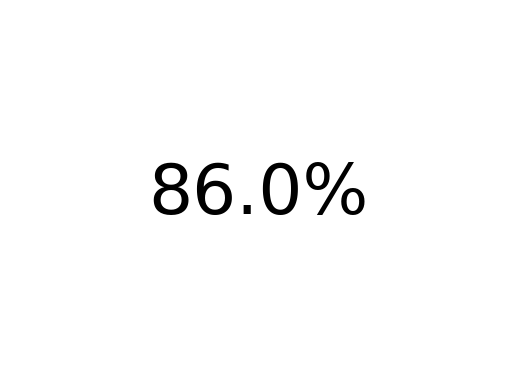

In [4932]:
round(df_nad_djok['1st_set_won'].sum()/df_nad_djok.shape[0],2) * 100
plt.text(0.5, 0.5, str(round(df_nad_djok['1st_set_won'].sum()/df_nad_djok.shape[0],2) * 100) + "%"
, fontsize=50, ha='center', va='center')
plt.axis('off')b

In [4937]:
df_nad_djok.groupby('surface').agg({'1st_set_won':['sum','count']})

1st_set_won      
                sum count
surface                  
Clay             24    28
Grass             3     4
Hard             24    27

In [4873]:
df_nad_djok['nw_sm'] = df_nad_djok.apply(lambda row: (lambda match: True if ((match.group(1)[0] < match.group(1)[2]) & (row['best_of'] == 3)
                                                                            or  ((match.group(1)[0] < match.group(1)[2]) & (match.group(2)[0] < match.group(2)[2])))
                                                      
                                                      else False)
                              (re.match(r'^(\d-\d)(?:\([^\)]*\))? (\d-\d)', row['score'])),axis=1)

/var/folders/pc/d4jq7b1522b7sxkg3p93hs3r0000gn/T/ipykernel_30229/539401502.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [4943]:
df_nad_djok[df_nad_djok['nw_sm'] == True][['winner_name']]

,winner_name
17660,Rafael Nadal
153957,Novak Djokovic
154052,Novak Djokovic
191811,Novak Djokovic


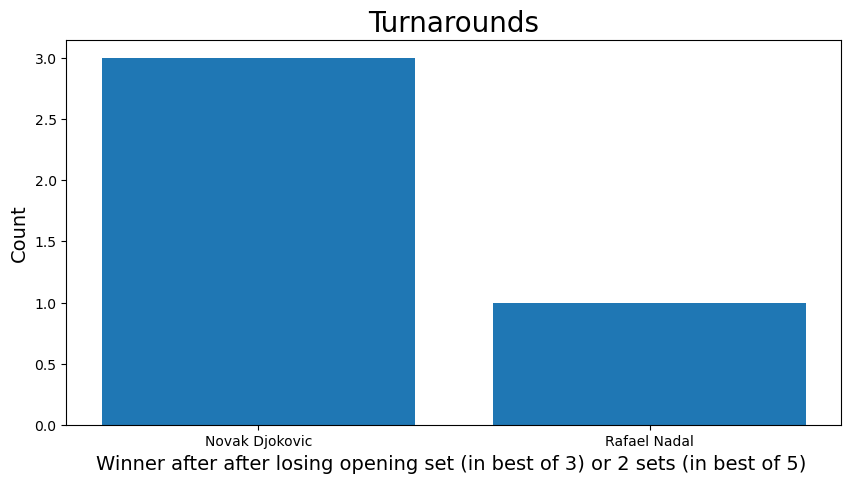

In [4997]:
backfrombehind =df_nad_djok[df_nad_djok['nw_sm'] == True]['winner_name'].value_counts()
plt.figure(figsize=(10,5))
plt.bar(backfrombehind.index, backfrombehind.values)
plt.title('Turnarounds',fontsize=20)
plt.xlabel('Winner after after losing opening set (in best of 3) or 2 sets (in best of 5) ',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.savefig('turaround.png',format='png')

In [4991]:
df_nad_djok[df_nad_djok['surface'] == 'Hard'].groupby(['winner_name']).agg({'w_bpSaved':'sum','l_bpSaved': 'sum'})

,w_bpSaved,l_bpSaved
winner_name,,
Novak Djokovic,51.0,88.0
Rafael Nadal,24.0,42.0


In [4449]:
df_nad_djok[df_nad_djok['surface'] == 'Grass'][['winner_name','w_ace','loser_name','l_ace']].groupby('winner_name').agg({'w_ace':'sum','l_ace':'sum'}).reset_index()

,winner_name,w_ace,l_ace
0,Novak Djokovic,30.0,14.0
1,Rafael Nadal,7.0,11.0


In [4548]:
#df_nad_djok[df_nad_djok['surface'] == 'Clay'][['winner_name','w_ace','loser_name','l_ace']]

df_nad_djok

In [4425]:
df_nad_djok[['tourney_name','winner_id','winner_name','w_ace','l_ace','winner_rank','loser_rank','minutes','best_of','tourney_level','surface','score','season']].sort_values(by='minutes', ascending=False).head(1)

,tourney_name,winner_id,winner_name,w_ace,l_ace,winner_rank,loser_rank,minutes,best_of,tourney_level,surface,score,season
162518,Australian Open,104925,Novak Djokovic,9.0,10.0,1.0,2.0,353.0,5,G,Hard,5-7 6-4 6-2 6-7(5) 7-5,2012


In [4540]:
df_nad_djok[['winner_name','round','tourney_level','tourney_name']]
df_nad_djok.groupby(['winner_name','round']).agg({'winner_name':'count'}).rename(columns={'winner_name':'count'})

count
winner_name    round       
Novak Djokovic F         16
               QF         3
               RR         1
               SF        10
Rafael Nadal   F         13
               QF         3
               RR         3
               SF        10

In [5072]:
#df_nad_djok[['winner_name','minutes','mins_per_set','sets_played','best_of']].sort_values(by=('mins_per_set'), ascending=False)
x  =50
df_nad_djok[df_nad_djok['mins_per_set'] > x][
'winner_name'
].value_counts().sort_index()


winner_name
Novak Djokovic    13
Rafael Nadal      19
Name: count, dtype: int64

In [5082]:
df_full[(df_full['tourney_level'] == 'G') & (df_full['round'] == 'F')][['winner_name','loser_name','tourney_name','minutes','score','season']].sort_values(by=('minutes'),ascending=False).head(20)

,winner_name,loser_name,tourney_name,minutes,score,season
162518,Novak Djokovic,Rafael Nadal,Australian Open,353.0,5-7 6-4 6-2 6-7(5) 7-5,2012
10394,Rafael Nadal,Daniil Medvedev,Australian Open,324.0,2-6 6-7(5) 6-4 6-4 7-5,2022
1628,Novak Djokovic,Roger Federer,Wimbledon,297.0,7-6(5) 1-6 7-6(4) 4-6 13-12(3),2019
164750,Andy Murray,Novak Djokovic,US Open,294.0,7-6(10) 7-5 2-6 3-6 6-2,2012
2179,Rafael Nadal,Daniil Medvedev,US Open,290.0,7-5 6-3 5-7 4-6 6-4,2019
16668,Rafael Nadal,Roger Federer,Wimbledon,288.0,6-4 6-4 6-7(5) 6-7(8) 9-7,2008
8841,Carlos Alcaraz,Novak Djokovic,Wimbledon,283.0,1-6 7-6(6) 6-1 3-6 6-4,2023
20110,Rafael Nadal,Roger Federer,Australian Open,259.0,7-5 3-6 7-6(3) 3-6 6-2,2009
19794,Roger Federer,Andy Roddick,Wimbledon,256.0,5-7 7-6(6) 7-6(5) 3-6 16-14,2009
22244,Novak Djokovic,Stefanos Tsitsipas,Roland Garros,251.0,6-7(6) 2-6 6-3 6-2 6-4,2021


In [4317]:
df_full[(df_full['season'] == 2023) & (df_full['tourney_level'] != 'D')][['tourney_name','tourney_id','tourney_level','surface','tourney_date']].drop_duplicates().to_csv('2023_tourneys.csv')

In [4319]:
df_tourney_cities = pd.read_csv('2023_tourney_cities_updated - 2023_tourneys.csv')

In [4321]:
df_tourney_cities

,Unnamed: 0,tourney_name,tourney_id,tourney_level,city,surface,lat,long,tourney_date
0,7120,United Cup,2023-9900,A,Sydney,Hard,-33.868820,151.209290,20230102
1,7168,Adelaide 1,2023-2843,A,Adelaide,Hard,34.927170,138.599533,20230102
2,7199,Pune,2023-0891,A,Pune,Hard,18.520430,73.856743,20230102
3,7226,Auckland,2023-0301,A,Auckland,Hard,-36.848461,174.763336,20230109
4,7253,Adelaide 2,2023-8998,A,Adelaide,Hard,34.927170,138.599533,20230109
...,...,...,...,...,...,...,...,...,...
62,9747,Paris Masters,2023-0352,M,Paris,Hard,48.856600,2.352200,20231030
63,9802,Metz,2023-0341,A,Metz,Hard,49.119300,6.175700,20231106
64,9829,Sofia,2023-7434,A,Sofia,Hard,42.697700,23.321900,20231106
65,9856,Tour Finals,2023-0605,A,Turin,Hard,45.070300,7.686900,20231113


In [4326]:
df_tourney_cities

,Unnamed: 0,tourney_name,tourney_id,tourney_level,city,surface,lat,long,tourney_date
0,7120,United Cup,2023-9900,A,Sydney,Hard,-33.868820,151.209290,20230102
1,7168,Adelaide 1,2023-2843,A,Adelaide,Hard,34.927170,138.599533,20230102
2,7199,Pune,2023-0891,A,Pune,Hard,18.520430,73.856743,20230102
3,7226,Auckland,2023-0301,A,Auckland,Hard,-36.848461,174.763336,20230109
4,7253,Adelaide 2,2023-8998,A,Adelaide,Hard,34.927170,138.599533,20230109
...,...,...,...,...,...,...,...,...,...
62,9747,Paris Masters,2023-0352,M,Paris,Hard,48.856600,2.352200,20231030
63,9802,Metz,2023-0341,A,Metz,Hard,49.119300,6.175700,20231106
64,9829,Sofia,2023-7434,A,Sofia,Hard,42.697700,23.321900,20231106
65,9856,Tour Finals,2023-0605,A,Turin,Hard,45.070300,7.686900,20231113


In [4328]:
icon_paths = {
    'Clay': 'orange_tennis_ball_circle.png',
    'Grass': 'green_tennis_ball_circle.png',
    'Hard': 'blue_tennis_ball_circle.png'
}

import random
from folium.features import CustomIcon
from folium.plugins import TimestampedGeoJson


def add_jitter(coord, scale=0.5):
    return coord + random.uniform(-scale, scale)


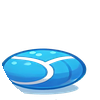
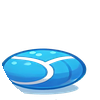
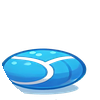
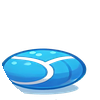
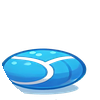
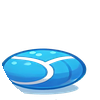
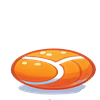
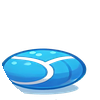
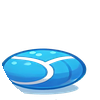
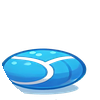
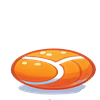
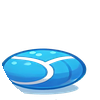
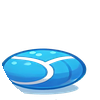
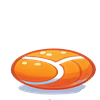
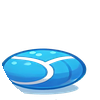
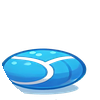
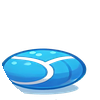
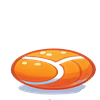
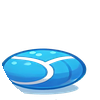
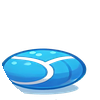
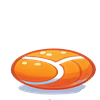
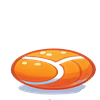
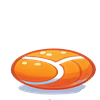
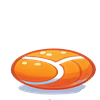
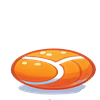
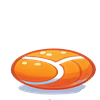
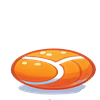
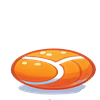
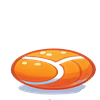
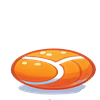
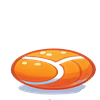
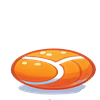
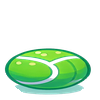
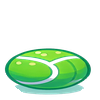
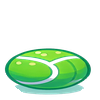
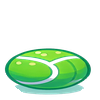
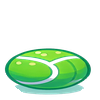
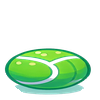
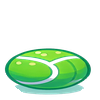
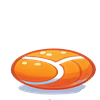
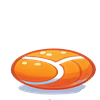
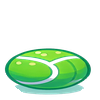
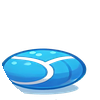
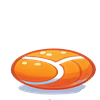
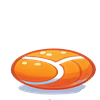
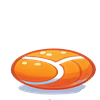
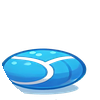
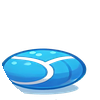
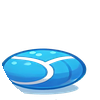
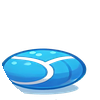
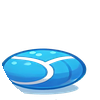
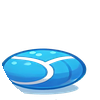
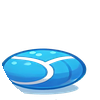
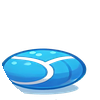
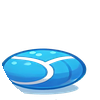
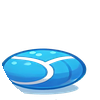
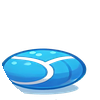
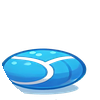
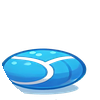
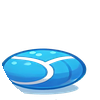
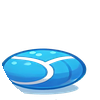
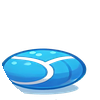
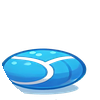
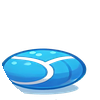
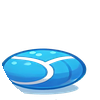
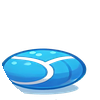
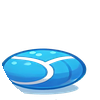

In [4330]:
import folium
import random
from folium.features import CustomIcon

# High-resolution tennis ball icon paths
icon_paths = {
    'Clay': 'orange_tennis_ball_circle.png',
    'Grass': 'green_tennis_ball_circle.png',
    'Hard': 'blue_tennis_ball_circle.png'
}

# Function to add a small random offset (jitter) to lat/long
def add_jitter(coord, scale=0.5):
    return coord + random.uniform(-scale, scale)

# Convert the tourney_date to datetime and extract the month
df_tourney_cities['tourney_date'] = pd.to_datetime(df_tourney_cities['tourney_date'], format='%Y%m%d')
df_tourney_cities['month'] = df_tourney_cities['tourney_date'].dt.month

# Create a map
m = folium.Map(location=[20, 0], zoom_start=2)

# Add tennis ball markers for each city, grouped by month
for month in sorted(df_tourney_cities['month'].unique()):
    # Create a separate layer for each month
    month_layer = folium.FeatureGroup(name=f'Month {month}').add_to(m)
    
    # Loop through the cities for that specific month
    for index, row in df_tourney_cities[df_tourney_cities['month'] == month].iterrows():
        if pd.notnull(row['lat']) and pd.notnull(row['long']):
            lat_with_jitter = add_jitter(row['lat'])
            long_with_jitter = add_jitter(row['long'])
            surface_type = row['surface']
            icon_path = icon_paths.get(surface_type, 'gray')  # Get the tennis ball icon for the surface type
            
            # Create a custom tennis ball icon
            icon = CustomIcon(icon_path, icon_size=(20, 20))  # Adjust the size if needed

            # Add the marker with the custom icon
            folium.Marker(
                location=[lat_with_jitter, long_with_jitter],
                icon=icon  # Set the custom tennis ball icon
            ).add_to(month_layer)

            # If the tourney_level is 'G', add the tournament name next to the icon
            if row['tourney_level'] == 'G':
                label = folium.DivIcon(
                    icon_size=(150, 36),
                    html=f'<div style="font-size: 10pt; color: black;">{row["tourney_name"]}</div>'
                )
                # Add label as a marker next to the icon
                folium.Marker(
                    location=[lat_with_jitter, long_with_jitter],
                    icon=label
                ).add_to(month_layer)

# Add LayerControl to switch between different month layers
folium.LayerControl().add_to(m)

# Save the map to an HTML file
m.save('cities_map_time_lapse_with_custom_icons.html')

# Show the map (for Jupyter Notebook)
m


In [4332]:
import folium
import random
from folium.features import CustomIcon
import calendar  # Import the calendar module

# High-resolution tennis ball icon paths
icon_paths = {
    'Clay': 'orange_tennis_ball_circle.png',
    'Grass': 'green_tennis_ball_circle.png',
    'Hard': 'blue_tennis_ball_circle.png'
}

# Function to add a small random offset (jitter) to lat/long
def add_jitter(coord, scale=0.5):
    return coord + random.uniform(-scale, scale)

# Convert the tourney_date to datetime and extract the month
df_tourney_cities['tourney_date'] = pd.to_datetime(df_tourney_cities['tourney_date'], format='%Y%m%d')
df_tourney_cities['month'] = df_tourney_cities['tourney_date'].dt.month

# Create a map
m = folium.Map(location=[20, 0], zoom_start=2)

# Add tennis ball markers for each city, grouped by month
month_layers = []  # Keep track of the month layers
for month in sorted(df_tourney_cities['month'].unique()):
    # Convert the month number to month name
    month_name = calendar.month_name[month]  # January, February, etc.
    
    # Create a separate layer for each month
    month_layer = folium.FeatureGroup(name=f'{month_name}', show=False)  # Set show=False so that none are initially visible
    month_layers.append(month_layer)
    
    # Loop through the cities for that specific month
    for index, row in df_tourney_cities[df_tourney_cities['month'] == month].iterrows():
        if pd.notnull(row['lat']) and pd.notnull(row['long']):
            lat_with_jitter = add_jitter(row['lat'])
            long_with_jitter = add_jitter(row['long'])
            surface_type = row['surface']
            icon_path = icon_paths.get(surface_type, 'gray')  # Get the tennis ball icon for the surface type
            
            # Create a custom tennis ball icon
            icon = CustomIcon(icon_path, icon_size=(20, 20))  # Adjust the size if needed

            # Add the marker with the custom icon
            folium.Marker(
                location=[lat_with_jitter, long_with_jitter],
                icon=icon  # Set the custom tennis ball icon
            ).add_to(month_layer)

            # If the tourney_level is 'G', add the tournament name next to the icon
            if row['tourney_level'] == 'G':
                label = folium.DivIcon(
                    icon_size=(150, 36),
                    html=f'<div style="font-size: 10pt; color: black;">{row["tourney_name"]}</div>'
                )
                # Add label as a marker next to the icon
                folium.Marker(
                    location=[lat_with_jitter, long_with_jitter],
                    icon=label
                ).add_to(month_layer)
    
    month_layer.add_to(m)  # Add the month layer to the map

# Add LayerControl to switch between different month layers
folium.LayerControl().add_to(m)

# Save the map to an HTML file
m.save('cities_map_time_lapse_with_custom_icons.html')

# Inject custom JavaScript for the time-lapse effect
with open('cities_map_time_lapse_with_custom_icons.html', 'a') as f:
    f.write('''
<script>
    var monthLayers = {};
    // Add each layer to the monthLayers dictionary for easy access
    {% for i, layer in enumerate(month_layers) %}
    monthLayers['{{ calendar.month_name[i+1] }}'] = {{ layer.get_name() }};
    {% endfor %}
    
    // Function to show layers one by one with a delay
    function showLayersSequentially(layers, delay) {
        var layerNames = Object.keys(layers);
        var index = 0;
        
        function showNextLayer() {
            if (index > 0) {
                map.removeLayer(layers[layerNames[index-1]]);
            }
            map.addLayer(layers[layerNames[index]]);
            index += 1;
            
            if (index < layerNames.length) {
                setTimeout(showNextLayer, delay);
            }
        }
        
        setTimeout(showNextLayer, delay);
    }
    
    // Run the time-lapse effect with a 5-second delay
    showLayersSequentially(monthLayers, 5000);
</script>
    ''')


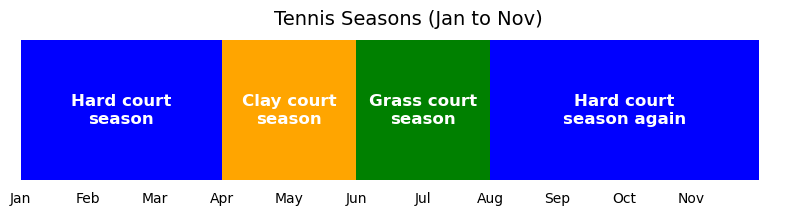

In [4334]:
import matplotlib.pyplot as plt
import numpy as np

# Define months and corresponding seasons (January to November)
months = np.arange(11)  # 11 months (0 = Jan, ..., 10 = Nov)

# Define the labels for the seasons and colors
season_labels = [
    'Hard court\nseason', 'Clay court\nseason', 'Grass court\nseason', 'Hard court\nseason again'
]
season_starts = [0, 3, 5, 7]  # Start positions for the seasons
season_lengths = [3, 2, 2, 4]  # Adjusted lengths to stop in November

season_colors = ['blue', 'orange', 'green', 'blue']  # Colors for the seasons

# Plotting
plt.figure(figsize=(10, 2))

# Create bars for each season
for i in range(len(season_labels)):
    plt.barh(0, season_lengths[i], left=season_starts[i], color=season_colors[i])

    # Add the text inside the corresponding colored bars with 'season' on the next line
    plt.text(season_starts[i] + season_lengths[i]/2, 0, season_labels[i], 
             ha='center', va='center', color='white', fontsize=12, weight='bold')

# Set ticks and labels for months (stopping at November)
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov']
plt.xticks(np.arange(11), month_names)

# Remove y-axis since it's not necessary
plt.yticks([])

# Add title
plt.title('Tennis Seasons (Jan to Nov)', fontsize=14)

# Remove the border and ticks for a cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().tick_params(axis='x', length=0)

# Show the plot
plt.savefig('Tennis Seasons.png', format='png')
plt.show()


In [5312]:
pairs_counts_min_max_season['mid'] = pairs_counts_min_max_season['season_min'] + (pairs_counts_min_max_season['season_max'] - pairs_counts_min_max_season['season_min'])/2 

In [5334]:
players[players['name_last'] == 'Becker']

#Michael Chang = 102021
#Courier = 101793
#Lendl = 100656
#Becker = 101414

#pair = (101793,102021)
#pair = (100656,101414)



,player_id,name_first,name_last,hand,dob,ioc,height,wikidata_id,cool_name
1413,101414,Boris,Becker,R,19671122.0,GER,190.0,Q76334,B. Becker (GER)
3793,103794,Benjamin,Becker,R,19810616.0,GER,178.0,Q77176,B. Becker (GER)
4571,104573,Jerome,Becker,R,19850622.0,GER,NaN,NaN,J. Becker (GER)
5688,105702,Richard,Becker,U,19910129.0,GER,NaN,Q16219372,R. Becker (GER)
7164,107179,Harvey,Becker,R,NaN,GBR,NaN,NaN,H. Becker (GBR)
7616,107631,Marc,Becker,R,NaN,GER,NaN,NaN,M. Becker (GER)
10187,110202,Roger,Becker,R,19340206.0,GBR,NaN,Q1565958,R. Becker (GBR)
10755,110770,Kai,Becker,R,19760302.0,GER,NaN,NaN,K. Becker (GER)
11537,111553,Ricky,Becker,U,19740319.0,USA,NaN,NaN,R. Becker (USA)
12889,112905,Jean,Becker,U,19150629.0,FRA,NaN,NaN,J. Becker (FRA)


In [5386]:
df_full[df_full['pair'] == (100656,101414)][['winner_name','tourney_name','round','surface','season']]

,winner_name,tourney_name,round,surface,season
65095,Ivan Lendl,Tokyo Indoor,QF,Carpet,1993
68704,Ivan Lendl,Masters,RR,Carpet,1987
78405,Boris Becker,Chicago,F,Carpet,1986
78845,Ivan Lendl,Stratton Mountain,F,Hard,1986
79150,Boris Becker,Sydney Indoor,F,Hard,1986
79552,Boris Becker,Wimbledon,F,Grass,1986
79684,Ivan Lendl,Masters Dec,F,Carpet,1986
82889,Ivan Lendl,Long Island,QF,Hard,1992
83074,Ivan Lendl,US Open,R16,Hard,1992
87723,Boris Becker,Stuttgart Indoor,F,Carpet,1990
